# Notebook Sumarizado

Esse notebook é um compilado de todos os outros utilizados para desenvolver o modelo, porém a forma que o modelo foi desenvolvido é todo por scripts python, os notebooks integralizados aqui são utilizados para teste e para desenvolver os scripts python. O código final utilizado para desenvolvimento do modelo **SEMPRE** é o dos scripts, exceto para as etapas de de análise e visualização!  

Caso queira replicar os resultados do modelo final apresentado você pode:
- Colocar o arquivo `fraud_dataset_v2.csv` na pasta `data/raw`  
- Criar um ambiente virtual e instalar os pacotes encontrados no requirements.txt na raiz do projeto  
- Acessar o terminal na raiz do projeto e executar os comandos abaixo:  

```bash
export PYTHONPATH=$(pwd)
make train
```

Com isso você terá todos os artefatos, bases intermediárias e arquivos de configuração replicados!  

# Avaliação do Baseline

Ao longo etapa será avaliado o modelo já existente para o dataset, avaliando tanto métricas de modelagem quanto métricas de negócio. O objetivo dessa analise é entender a performance e estabilidade do modelo atual.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score, auc
import matplotlib.pyplot as plt
from scipy.stats import kstest
from datetime import datetime

## Dados

In [2]:
df = pd.read_csv('../data/raw/fraud_dataset_v2.csv', index_col=0)

In [3]:
print(df.shape)
print(df.drop_duplicates().shape)
df.head(2)

(250000, 23)
(250000, 23)


a       b         c     d         e     f   g  h  \
0  4  0.7685  94436.24  20.0  0.444828   1.0  BR  5   
1  4  0.7550   9258.50   1.0  0.000000  33.0  BR  0   

                                                   i            j  ...  n  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  ...  1   
1  Avental Descartavel Manga Longa  - 50 Un. Tnt ...  cat_64b574b  ...  1   

     o  p     q      r  s                fecha   monto  score fraude  
0  NaN  N  0.40  94436  0  2020-03-27 11:51:16    5.64   66.0      0  
1    Y  N  0.02   9258  0  2020-04-15 19:58:08  124.71   72.0      0  

[2 rows x 23 columns]

## Métricas dos Dados

In [4]:
print(f'Bad rate: {df.fraude.mean()}')
print(f'Qtd. Maus: {df.fraude.sum()}\nQtd. Bons: {df.shape[0]-df.fraude.sum()}')

Bad rate: 0.030008
Qtd. Maus: 7502
Qtd. Bons: 242498


Antes de começar a análise do score é importante entender algumas métricas da tabela para escolher as melhores métricas para avalia-lo.  
Já nos foi adiantado que é dataset é de fraude em um e-commerce, fazendo uma segunda validação temos um problema desbalanceado, 3%/300 BPs, com isso vamos utilizar métricas para esse tipo de problema:  
- ROC AUC  
- PR AUC  
- Precision  Qtd. e Financeiro  
- Recall  Qtd. e Financeiro 

Além das métricas de modelagem também vamos avaliar uma métrica de ROI indicada pelo time de negócio.  

## Métricas do Baseline

In [7]:
df[['score', 'fraude', 'monto', 'fecha']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   score   250000 non-null  float64
 1   fraude  250000 non-null  int64  
 2   monto   250000 non-null  float64
 3   fecha   250000 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 9.5+ MB


Não enconstramso nenhum nulo nas colunas que vamos utilizar durante essa análise, então vamos seguir sem tratar, isso será realizado no momento da modelagem do novo modelo.

## Métricas de Modelagem

In [8]:
# A fraude parece estar nume dimens]ao menor que o score, não parece estar evoluindo junto com as casas decimais, talvez 
# de pra reduzir essas casas, não estão agregando no score
df['valor_fraude'] = df['monto'] * df['fraude']
df_thresholds = (
    df
    .groupby('score')
    .agg({'fraude' : ['sum', 'count'],
          'valor_fraude' : 'sum',
          'monto' : 'sum'})
    .sort_values(by='score', ascending=False)
    .cumsum()
    .reset_index()
)
df_thresholds.columns = ['score', 'qtd_fraude', 'qtd_total', 'valor_fraude', 'valor_total']
df_thresholds['fpr_#'] = (df_thresholds['qtd_total'] - df_thresholds['qtd_fraude'])/(df_thresholds['qtd_total'].max() - df_thresholds['qtd_fraude'].max())
df_thresholds['fpr_$'] = (df_thresholds['valor_total'] - df_thresholds['valor_fraude'])/(df_thresholds['valor_total'].max() - df_thresholds['valor_fraude'].max())
df_thresholds['precision_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_total']
df_thresholds['precision_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_total']
df_thresholds['recall_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_fraude'].max()
df_thresholds['recall_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_fraude'].max()
df_thresholds.iloc[188:195,:]

score  qtd_fraude  qtd_total  valor_fraude  valor_total     fpr_#  \
188  98.03         743       3350      50684.80    197839.97  0.010751   
189  98.02         743       3355      50684.80    198072.45  0.010771   
190  98.01         743       3361      50684.80    198332.26  0.010796   
191  98.00         924       4074      65861.12    248762.36  0.012990   
192  97.99         924       4078      65861.12    248848.15  0.013006   
193  97.98         924       4083      65861.12    249242.60  0.013027   
194  97.97         924       4086      65861.12    249317.18  0.013039   

        fpr_$  precision_#  precision_$  recall_#  recall_$  
188  0.014201     0.221791     0.256191  0.099040  0.092609  
189  0.014223     0.221461     0.255890  0.099040  0.092609  
190  0.014248     0.221065     0.255555  0.099040  0.092609  
191  0.017650     0.226804     0.264755  0.123167  0.120338  
192  0.017659     0.226582     0.264664  0.123167  0.120338  
193  0.017697     0.226304     0.264245  0.123167  0.120338  
194  0.017704     0.226138     0.264166  0.123167  0.120338

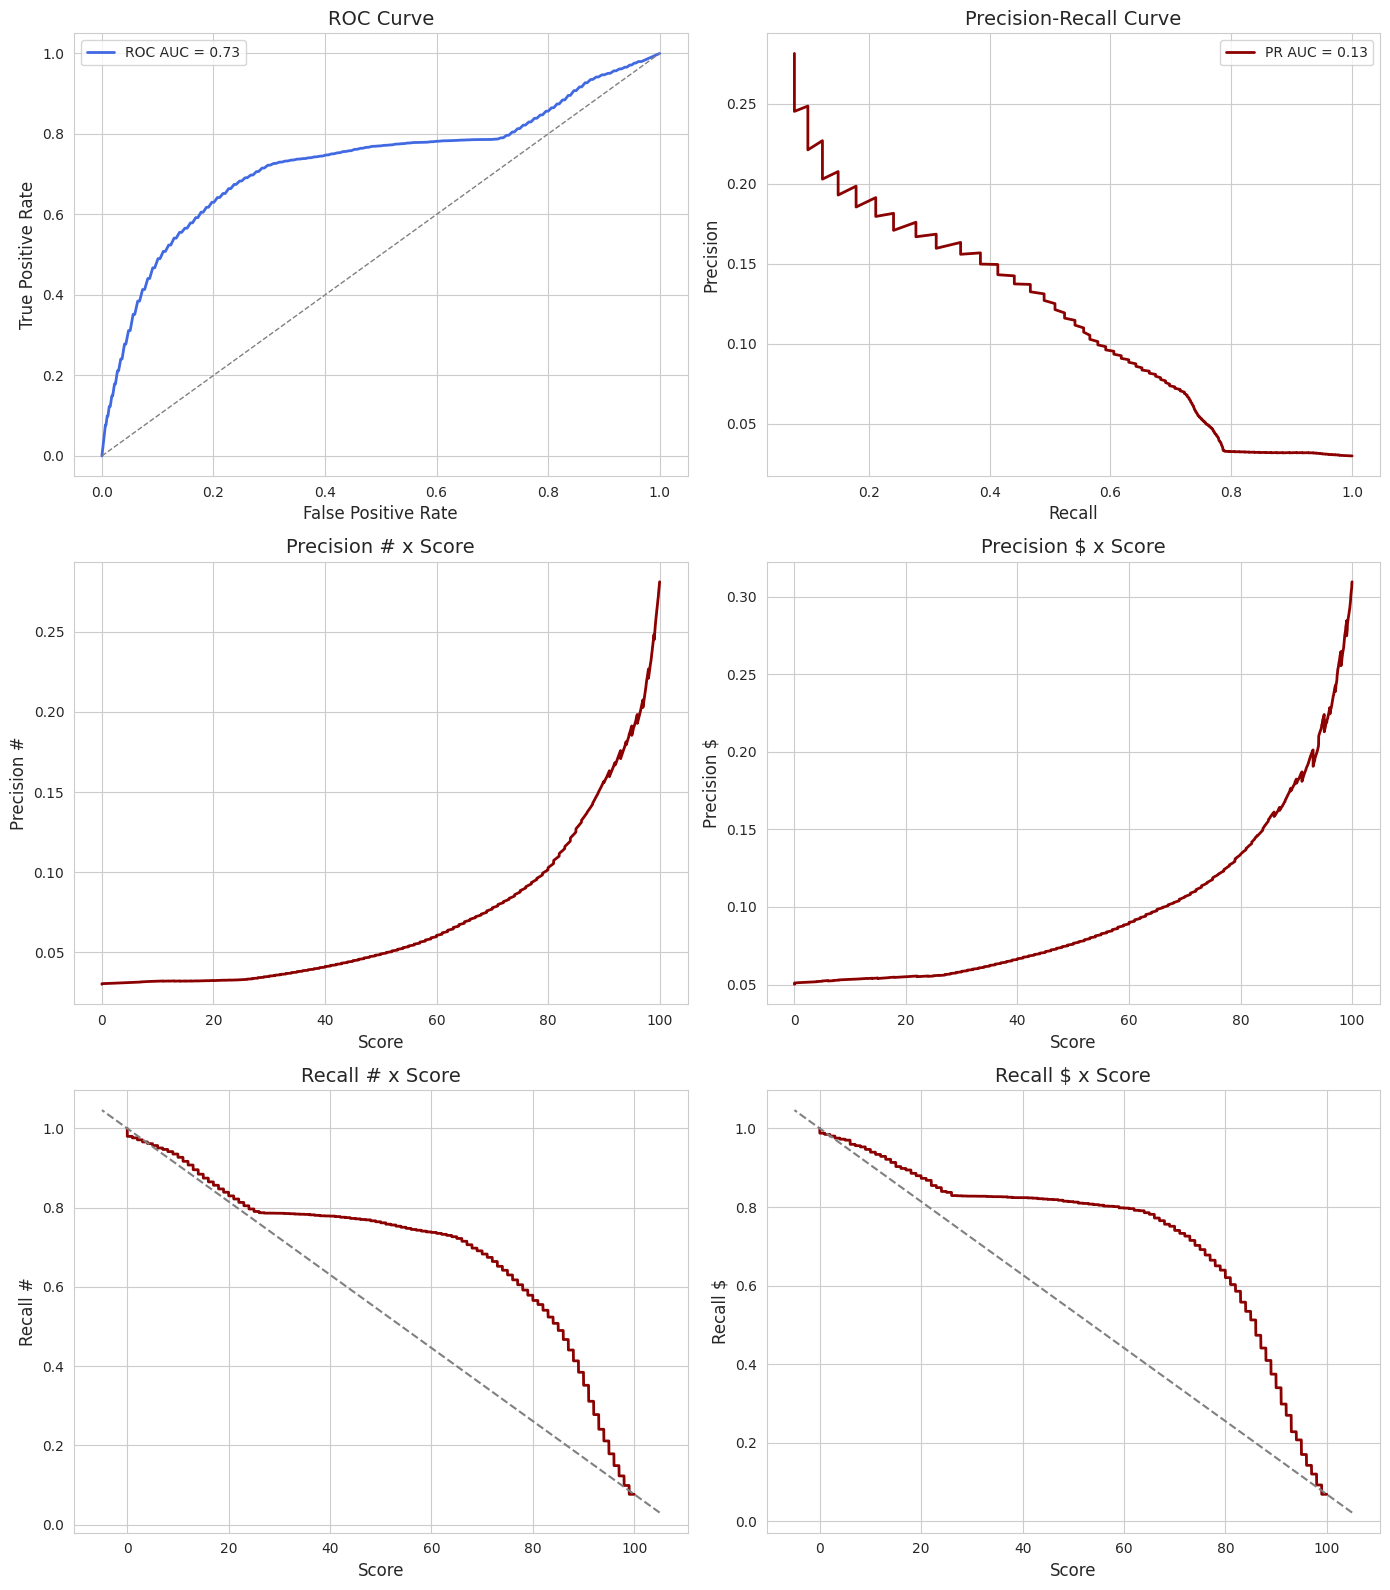

In [9]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(14, 16))
colors = ["royalblue", "darkred"]

# ROC Curve
fpr, tpr, th_roc = roc_curve(df['fraude'], df['score'])
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color=colors[0], linewidth=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14)
axes[0, 0].legend()

# Precision-Recall Curve
pr_auc = average_precision_score(df['fraude'], df['score'])
axes[0, 1].plot(df_thresholds['recall_#'], df_thresholds['precision_#'], color=colors[1], linewidth=2, label=f'PR AUC = {pr_auc:.2f}')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14)
axes[0, 1].legend()

# Precision # x Score Curve
axes[1, 0].plot(df_thresholds['score'], df_thresholds['precision_#'], color=colors[1], linewidth=2)
axes[1, 0].set_xlabel('Score', fontsize=12)
axes[1, 0].set_ylabel('Precision #', fontsize=12)
axes[1, 0].set_title('Precision # x Score', fontsize=14)

# Precision $ x Score Curve
axes[1, 1].plot(df_thresholds['score'], df_thresholds['precision_$'], color=colors[1], linewidth=2)
axes[1, 1].set_xlabel('Score', fontsize=12)
axes[1, 1].set_ylabel('Precision $', fontsize=12)
axes[1, 1].set_title('Precision $ x Score', fontsize=14)

# Recall # x Score Curve
axes[2, 0].plot(df_thresholds['score'], df_thresholds['recall_#'], color=colors[1], linewidth=2)
axes[2, 0].set_xlabel('Score', fontsize=12)
axes[2, 0].set_ylabel('Recall #', fontsize=12)
axes[2, 0].set_title('Recall # x Score', fontsize=14)

# Recall $ x Score Curve
axes[2, 1].plot(df_thresholds['score'], df_thresholds['recall_$'], color=colors[1], linewidth=2)
axes[2, 1].set_xlabel('Score', fontsize=12)
axes[2, 1].set_ylabel('Recall $', fontsize=12)
axes[2, 1].set_title('Recall $ x Score', fontsize=14)

for ax in [axes[2, 0], axes[2, 1]]:
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.plot([x_max, x_min], [y_min, y_max], color='gray', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.show()

É possível enxergar um comportamento estranho no score abaixo de 20, indicando quase que aleatoriedade

## Distribuição

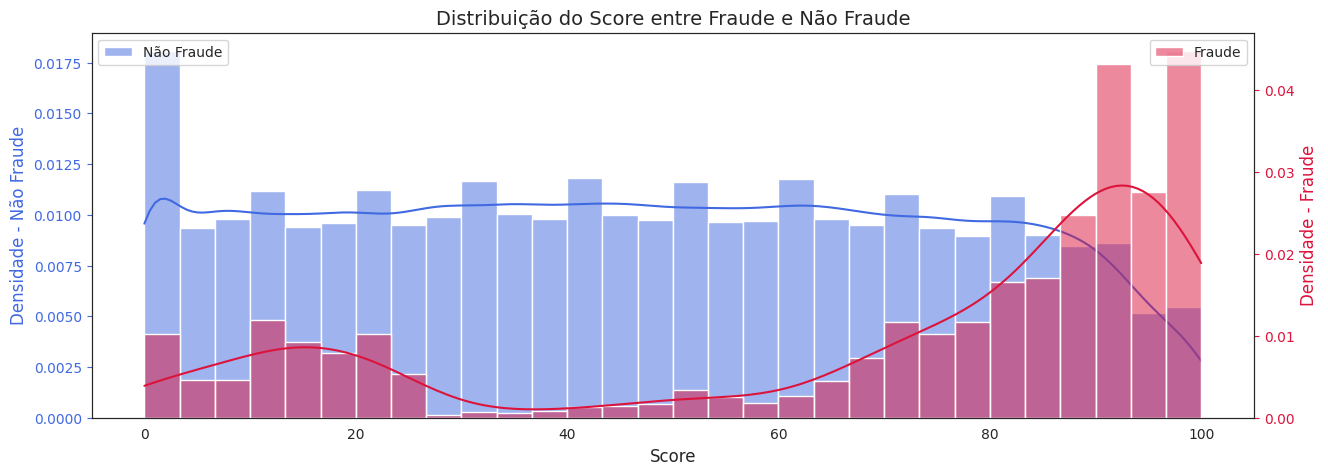

In [10]:
sns.set_style("white")

plt.figure(figsize=(15, 5))

ax1 = plt.gca()
ax2 = ax1.twinx()

sns.histplot(
    data=df[df['fraude'] == 0], x="score", kde=True, stat="density",
    bins=30, color="royalblue", alpha=0.5, label="Não Fraude", ax=ax1
)

sns.histplot(
    data=df[df['fraude'] == 1], x="score", kde=True, stat="density",
    bins=30, color="crimson", alpha=0.5, label="Fraude", ax=ax2
)

ax1.set_xlabel("Score", fontsize=12)
ax1.set_ylabel("Densidade - Não Fraude", color="royalblue", fontsize=12)
ax2.set_ylabel("Densidade - Fraude", color="crimson", fontsize=12)

ax1.tick_params(axis="y", colors="royalblue")
ax2.tick_params(axis="y", colors="crimson")

plt.title("Distribuição do Score entre Fraude e Não Fraude", fontsize=14)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

A distribuição do score nos ajuda a enxergar essa possível aleatoriedade no score abaixo de 20, vemos um acumulo de fraudes concentrado nessa faixa.  
Também é possível notar uma grande concentração de transações boas nos scores altos, indicando um alto nível de falso positivo.  

### Avaliação ao longo do tempo

In [11]:
df['anomesdia'] = df['fecha'].str[0:10].str.replace('-','', regex=True).astype(int)

In [12]:
df_auc_safrada = pd.DataFrame([
    [
        str(anomesdia),
        roc_auc_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        average_precision_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        df[df['anomesdia'] == anomesdia]['fraude'].mean(),
        df[df['anomesdia'] == anomesdia].shape[0],
        df[df['anomesdia'] == anomesdia]['fraude'].sum()
    ]
    for anomesdia in df['anomesdia'].unique()
], columns=['anomesdia', 'roc_auc', 'pr_auc', 'br', 'qtd_trans', 'qtd_fraude']).sort_values(by='anomesdia')



In [13]:
df_auc_safrada['media_movel_roc_auc'] = df_auc_safrada['roc_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_pr_auc'] = df_auc_safrada['pr_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_br'] = df_auc_safrada['br'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_trans'] = df_auc_safrada['qtd_trans'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_fraude'] = df_auc_safrada['qtd_fraude'].rolling(window=7).mean()

/tmp/ipykernel_61811/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_61811/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_61811/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_61811/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_61811/4173622012.py:20: UserWarning: set_tick

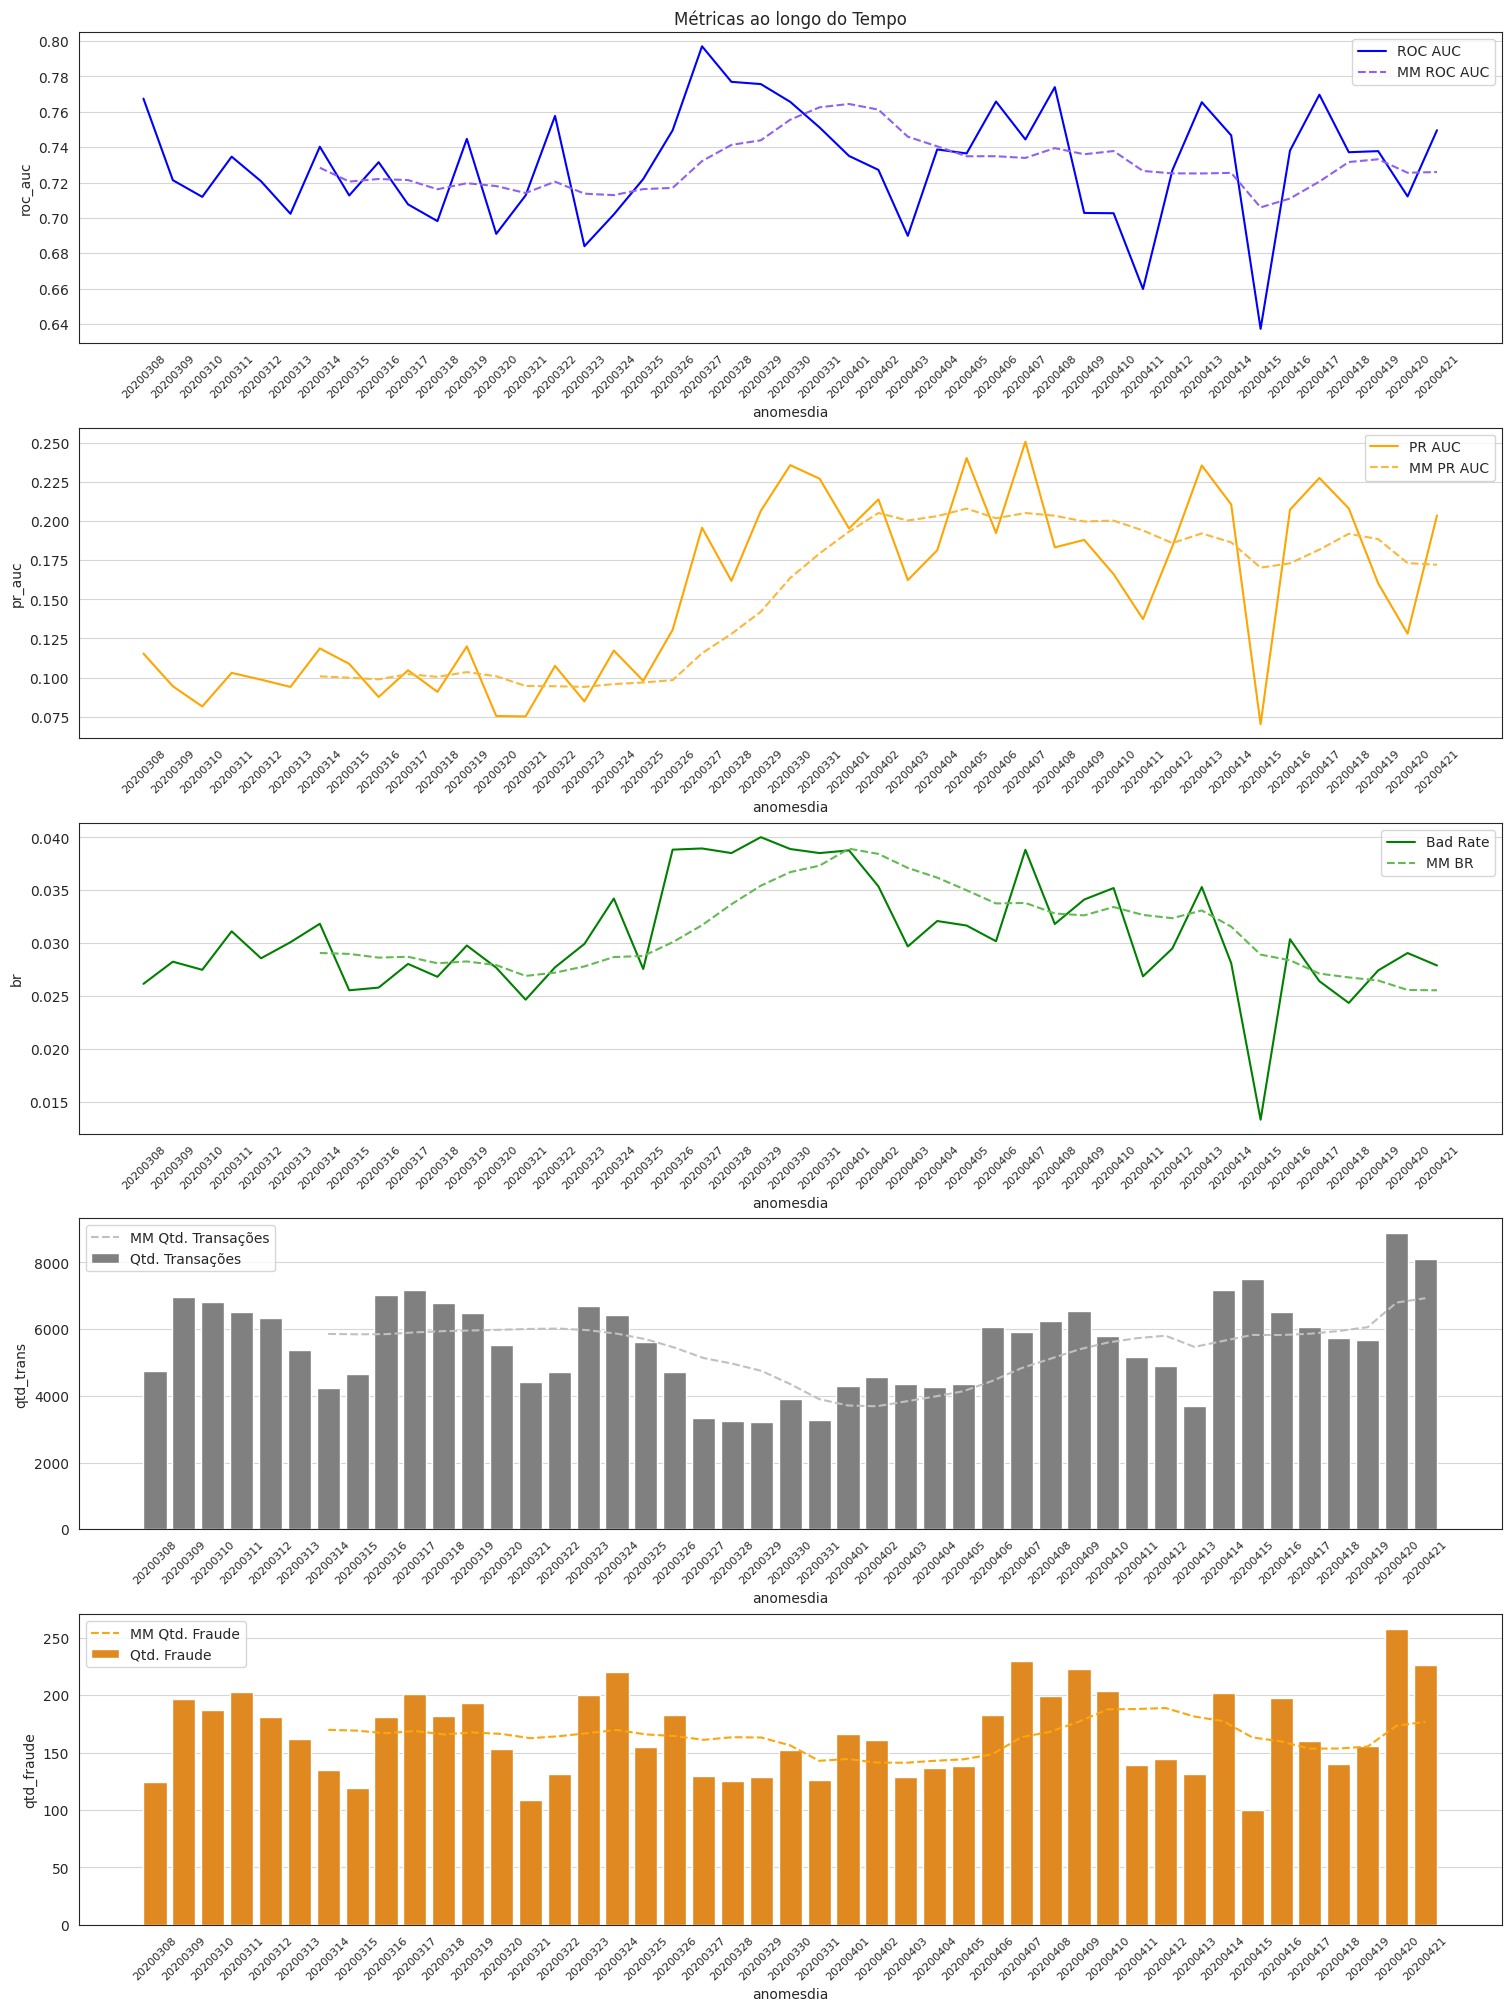

In [14]:
sns.set_style("white")

fig, axes = plt.subplots(5, 1, figsize=(15, 20),constrained_layout=True)
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='roc_auc', label='ROC AUC', ax=axes[0], color='blue')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_roc_auc', label='MM ROC AUC', ax=axes[0], linestyle="--", color='#8f61f3')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='pr_auc', label='PR AUC', ax=axes[1], color='orange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_pr_auc', label='MM PR AUC', ax=axes[1], linestyle="--", color='#fbb73a')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='br', label='Bad Rate', ax=axes[2], color='green')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_br', label='MM BR', ax=axes[2], linestyle="--", color='#61bb50')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_trans', label='Qtd. Transações', ax=axes[3], color='grey')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_trans', label='MM Qtd. Transações', ax=axes[3], linestyle="--", color='#c0c0c0')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_fraude', label='Qtd. Fraude', ax=axes[4], color='darkorange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_fraude', label='MM Qtd. Fraude', ax=axes[4], linestyle="--", color='#fea50d')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
    ax.grid(axis='y', linestyle="-", alpha=0.8)

axes[0].set_title('Métricas ao longo do Tempo')
plt.show()

É possível notar uma variação das métricas ao longo do tempo, e não parecem estar relacionadas a um aumento/queda da taxa de fraudes, visto que por mais que a badrate aumente as métricas de prauc e rocauc aumentem também, quando a bad rate retorna ao seu valor usual as métricas não tem nenhuma queda.  

Então essa variação de performance pode esta relacionada a um retreino do modelo ou então modus operandi da fraude.  

Já a variação da bad rate pode ser algum efeito de sazonalidade de final de mês, onde temos a redução no volume geral de transações que não foi acompanhado por uma redução na quantidade de fraudes.  

### Estabilidade do Score

Para avaliar a estabilidade do score vamos usar o teste KS, avaliando duas distribuições, para isso vou utilizar a primeira semana do dataset como referência e comparar sempre o mesmo dia da semana, visto que temos sazonalidade em dias da semana.  

In [15]:
ks_day_map = {
    'Sunday' : 20200308,
    'Monday' : 20200309,
    'Tuesday' : 20200310,
    'Wednesday' : 20200311,
    'Thursday' : 20200312,
    'Friday' : 20200313,
    'Saturday' : 20200314
}

df_ks_safrado = pd.DataFrame(
    [
        [
            str(anomesdia),
            kstest(df[df['anomesdia'] == ks_day_map.get(datetime.strptime(str(anomesdia), "%Y%m%d").strftime("%A"))]['score'], 
                   df[df['anomesdia'] == anomesdia]['score'])[0]
        ]
        for anomesdia in df['anomesdia'].unique() if int(anomesdia) >= 20200315
    ],
    columns=['anomesdia', 'ks']
).sort_values(by='anomesdia')

In [16]:
df['faixa_score'] = pd.cut(df['score'], bins=range(0, 100, 5), include_lowest=True)
df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)
df_percentual = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
df_percentual.index = df_percentual.index.astype(str)

/tmp/ipykernel_61811/663662827.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)


/tmp/ipykernel_61811/124477336.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)


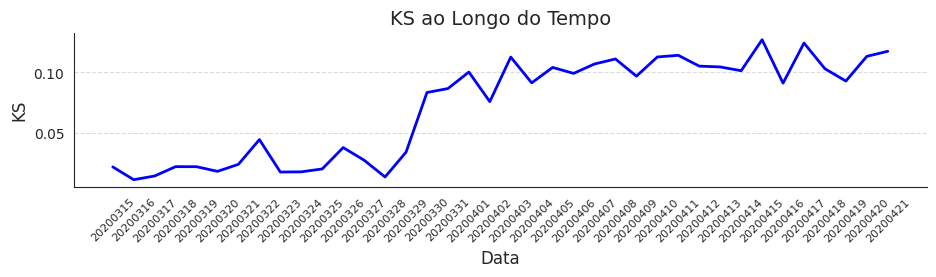

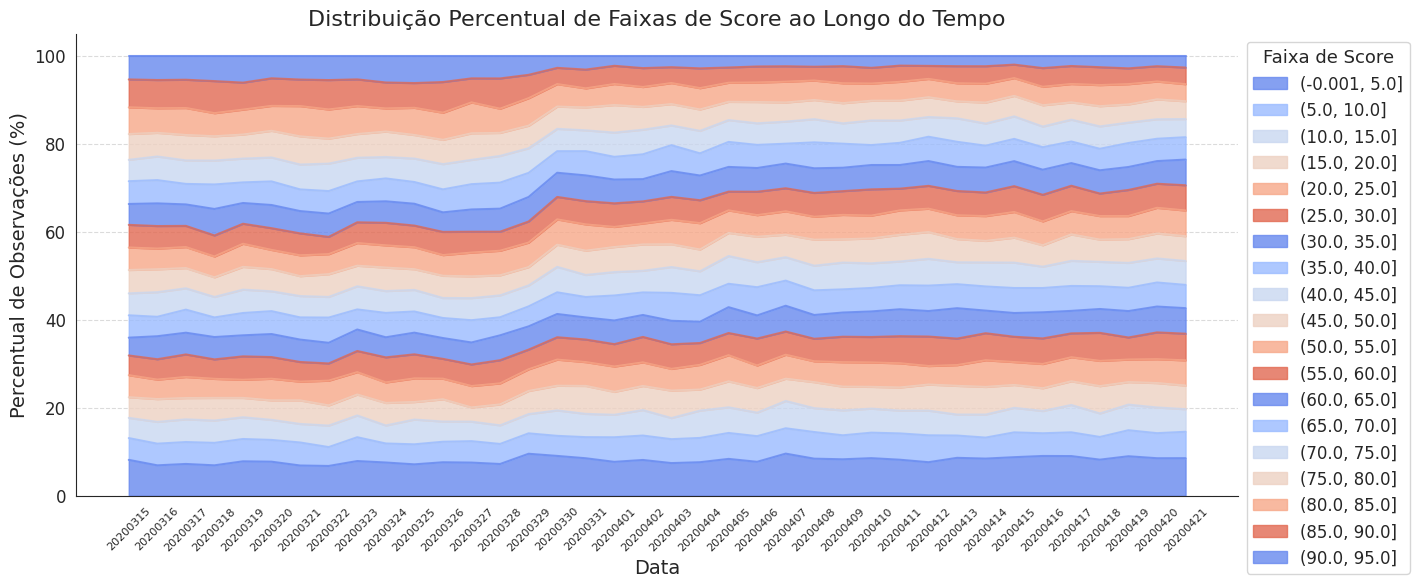

In [17]:
# KS
plt.figure(figsize=(11, 2))

sns.set_palette("coolwarm")

ax = sns.lineplot(data=df_ks_safrado, x='anomesdia', y='ks', linewidth=2, color='blue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

ax.set_title('KS ao Longo do Tempo', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('KS', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Distribuição Faixas de Score
ax = df_percentual.plot(kind='area', stacked=True, figsize=(15, 6), alpha=0.8)

plt.xlabel("Data", fontsize=14)
plt.ylabel("Percentual de Observações (%)", fontsize=14)
plt.title("Distribuição Percentual de Faixas de Score ao Longo do Tempo", fontsize=16)

plt.xticks(ticks=np.arange(len(df_percentual.index)), labels=df_percentual.index, rotation=45, fontsize=8)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(title="Faixa de Score", fontsize=12, title_fontsize=13, loc='upper left', bbox_to_anchor=(1, 1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

Avaliando o KS para entender um possível drift no score a partir de 20200330, o teste do KS nos mostra que a partir dessa data é possível descartar a hipotese nula, mostrando que houve algo nesse dia que impactou na distribuição do score, pode ser um retreino ou algum drift de uma variável importânte para esse score, ou até mesmo uma mudança de perfil da fraude.  
A única cois que podemos afirmar é que aconteceu algo no dia 20200330!  

In [ ]:
df_retreino = df[df['anomesdia'] >= 20200327].reset_index(drop=True)
df_ant_retreino = df[df['anomesdia'] < 20200327].reset_index(drop=True)

In [ ]:
print(roc_auc_score(df_ant_retreino['fraude'], df_ant_retreino['score']))
print(roc_auc_score(df_retreino['fraude'], df_retreino['score']))

print(average_precision_score(df_ant_retreino['fraude'], df_ant_retreino['score']))
print(average_precision_score(df_retreino['fraude'], df_retreino['score']))

0.7204282573847495
0.7381962297144454
0.0977373473264336
0.18171346131675495


Avaliando as métricas antes e depois do evento, é possível notar que o score ganhou performance após 20200330, mostrando possívelmente um retreino.  

# Modelagem

## Separação dos Dados

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

### Dados

In [22]:
df = pd.read_csv('../data/raw/fraud_dataset_v2.csv', index_col=0)

In [23]:
df.head(2)

a       b         c     d         e     f   g  h  \
0  4  0.7685  94436.24  20.0  0.444828   1.0  BR  5   
1  4  0.7550   9258.50   1.0  0.000000  33.0  BR  0   

                                                   i            j  ...  n  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  ...  1   
1  Avental Descartavel Manga Longa  - 50 Un. Tnt ...  cat_64b574b  ...  1   

     o  p     q      r  s                fecha   monto  score fraude  
0  NaN  N  0.40  94436  0  2020-03-27 11:51:16    5.64   66.0      0  
1    Y  N  0.02   9258  0  2020-04-15 19:58:08  124.71   72.0      0  

[2 rows x 23 columns]

### Separação

Para treino será utilizado 80% do período [20200308, 20200407].  
Para validação será utilizado 20% restante do período de treino [20200308, 20200407].  
Para teste será utilizado 100% do período [20200408, 20200421].  

Vou utilizar uma técnica de out-of-time para o período de teste do modelo e uma técnica de out-of-sample para as partes de hipertunning/substituição de nulos/feature selection, evitando data leak.  

In [28]:
df_train = df[
    (df['fecha'].astype('datetime64[s]') >= pd.to_datetime('2020-03-08')) &
    (df['fecha'].astype('datetime64[s]') <= pd.to_datetime('2020-04-07'))             
].reset_index(drop=True)

In [25]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train['fraude'], random_state=777)

In [29]:
df_test = df[
    (df['fecha'].astype('datetime64[s]') >= pd.to_datetime('2020-04-08'))         
].reset_index(drop=True)

In [33]:
print(df_train.shape, df_train.fraude.mean())
print(df_valid.shape, df_valid.fraude.mean())
print(df_test.shape, df_test.fraude.mean())

(156055, 23) 0.030707122488866104
(31211, 23) 0.030694306494505143
(88022, 23) 0.028174774488196132


A base de teste esta com uma leve queda na bad rate, podemos esperar uma performance menor devido a isso.  

In [30]:
df_train.to_parquet(
    '../data/raw/fraud_dataset_v2_train.parquet.gzip',
    compression='gzip',
    index=False
)

In [31]:
df_valid.to_parquet(
    '../data/raw/fraud_dataset_v2_valid.parquet.gzip',
    compression='gzip',
    index=False
)

In [32]:
df_test.to_parquet(
    '../data/raw/fraud_dataset_v2_test.parquet.gzip',
    compression='gzip',
    index=False
)

## Preparação dos Dados

In [55]:
import pandas as pd
import numpy as np
import sys
import yaml
sys.path.append('../src/')

from utils.transformers import FixFeaturesType, FixFeaturesMissing
from utils.modeling import apply_encoders

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Data

In [45]:
df_train = pd.read_parquet('../data/raw/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/raw/fraud_dataset_v2_valid.parquet.gzip')
df_test = pd.read_parquet('../data/raw/fraud_dataset_v2_test.parquet.gzip')

In [47]:
df_train.head(2)

a       b          c     d         e     f   g   h  \
0  4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1  4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   

        l      m  n     o  p     q       r  s                fecha   monto  \
0   240.0  102.0  1  None  N  0.40   94436  0  2020-03-27 11:51:16    5.64   
1  1779.0   77.0  1  None  N  0.06  242549  0  2020-03-25 18:13:38  339.32   

   score  fraude  
0   66.0       0  
1   95.0       0

In [48]:
df_info = df_train.describe(include='all').T
df_info['tipo_coluna'] = df_train.dtypes
df_info['qtd_unicos'] = df_train.nunique()
df_info['tipo_final'] = df_info['qtd_unicos'].apply(lambda x: 'categorica' if x <= 70 else 'numerica')
df_info

count unique                                          top    freq  \
a       156055.0    NaN                                          NaN     NaN   
b       135368.0    NaN                                          NaN     NaN   
c       135368.0    NaN                                          NaN     NaN   
d       155612.0    NaN                                          NaN     NaN   
e       156055.0    NaN                                          NaN     NaN   
f       156043.0    NaN                                          NaN     NaN   
g         155945     44                                           BR  117299   
h       156055.0    NaN                                          NaN     NaN   
i         156055  83222  Fone De Ouvido Sem Fio Xiaomi Airdots Preto     104   
j         156055   7344                                  cat_43b9c10    2318   
k       156055.0    NaN                                          NaN     NaN   
l       156043.0    NaN                                          NaN     NaN   
m       155612.0    NaN                                          NaN     NaN   
n       156055.0    NaN                                          NaN     NaN   
o          41454      2                                            Y   25169   
p         156055      2                                            Y   87849   
q       155612.0    NaN                                          NaN     NaN   
r       156055.0    NaN                                          NaN     NaN   
s       156055.0    NaN                                          NaN     NaN   
fecha     156055  91267                          2020-03-20 21:04:15       6   
monto   156055.0    NaN                                          NaN     NaN   
score   156055.0    NaN                                          NaN     NaN   
fraude  156055.0    NaN                                          NaN     NaN   

                 mean            std       min        25%        50%  \
a            3.692903       0.919744       0.0        3.0        4.0   
b            0.725065       0.133835       0.0     0.6764     0.7518   
c       249080.806777  811237.559337      0.16  9479.3125  42644.175   
d           21.631821        19.9706      -1.0        3.0       14.0   
e            0.210949       1.300892       0.0        0.0   0.092123   
f           53.623328     714.829907      -5.0        2.0        9.0   
g                 NaN            NaN       NaN        NaN        NaN   
h           14.274275      14.107061      -1.0        3.0        9.0   
i                 NaN            NaN       NaN        NaN        NaN   
j                 NaN            NaN       NaN        NaN        NaN   
k            0.497277       0.288099  0.000004   0.246749   0.495327   
l         2324.313292    1710.636068      -1.0      927.0     1959.0   
m           302.06878     319.820792      -1.0       44.0      198.0   
n            0.909436       0.286989       0.0        1.0        1.0   
o                 NaN            NaN       NaN        NaN        NaN   
p                 NaN            NaN       NaN        NaN        NaN   
q            0.422588       0.399385     -0.02       0.04       0.28   
r       250586.840806  755566.418461       0.0    12597.0    61477.0   
s           56.293614      49.602482       0.0        0.0      100.0   
fecha             NaN            NaN       NaN        NaN        NaN   
monto       44.976062      89.973409      0.02      10.54      22.36   
score       49.238444       29.34093       0.0       24.0      49.74   
fraude       0.030707       0.172524       0.0        0.0        0.0   

                75%          max tipo_coluna  qtd_unicos  tipo_final  
a               4.0          5.0       int64           6  categorica  
b            0.8034          1.0     float64        7002    numerica  
c       141599.9425  13878743.71     float64       80395    numerica  
d              49.0         51.0     float64          53  categorica  
e     

Avaliando as tabelas acima será necessário vamos realizar alguns ajustes de tipo e nulo.  
Ajustes de Tipo:  
- Ajustar coluna de data 'fecha' para tipo timestamp  

Ajuste de Nulos:  
- Ajustar colunas ['d', 'g', 'o', 'q'], para as colunas categóricas vou criar uma nova categoria indicando o nulo. 
- Ajustar colunas ['b', 'c', 'f', 'l', 'm'], para as colunas numéricas vou realizar uma substituição utilizando a mediana, para isso vou utilizar o conjunto de validação.  

Colunas com até 70 valores únicos foram definidas como colunas do tipo categórico e colunas com mais foram definidas como numéricas.  


### Ajuste de Tipos

In [49]:
config_features = yaml.safe_load(open('../src/data/config/features.yml', 'r'))

In [50]:
fix_features = FixFeaturesType(config_features['fix_type_map'])

In [51]:
df_tmp = fix_features.transform(df_valid)

### Ajuste de Missings

In [52]:
fix_missing = FixFeaturesMissing(config_features['fix_missing_numeric_features'],
                                 config_features['fix_missing_map'])

In [53]:
df_tmp = fix_missing.fit_transform(df_tmp)

In [54]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31211 entries, 0 to 31210
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   a       31211 non-null  int64        
 1   b       31211 non-null  float64      
 2   c       31211 non-null  float64      
 3   d       31211 non-null  float64      
 4   e       31211 non-null  float64      
 5   f       31211 non-null  float64      
 6   g       31211 non-null  object       
 7   h       31211 non-null  int64        
 8   i       31211 non-null  object       
 9   j       31211 non-null  object       
 10  k       31211 non-null  float64      
 11  l       31211 non-null  float64      
 12  m       31211 non-null  float64      
 13  n       31211 non-null  int64        
 14  o       31211 non-null  object       
 15  p       31211 non-null  object       
 16  q       31211 non-null  float64      
 17  r       31211 non-null  int64        
 18  s       31211 non-null  in

In [56]:
for df_, group in [(df_train, 'train'), (df_valid, 'valid'), (df_test, 'test')]:
    df_ = apply_encoders(df_, [fix_features, fix_missing])

    df_.to_parquet(f'../data/interim/fraud_dataset_v2_{group}.parquet.gzip', 
                   compression='gzip', index=False)

Todas as colunas ajustadas com sucesso!

## Feature Engineering

In [57]:
import pandas as pd
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Data

In [58]:
df_train = pd.read_parquet('../data/interim/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/interim/fraud_dataset_v2_valid.parquet.gzip')
df_test = pd.read_parquet('../data/interim/fraud_dataset_v2_test.parquet.gzip')

In [60]:
df_train.head(2)

a       b          c     d         e     f   g   h  \
0  4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1  4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   

        l      m  n     o  p     q       r  s               fecha   monto  \
0   240.0  102.0  1  NULO  N  0.40   94436  0 2020-03-27 11:51:16    5.64   
1  1779.0   77.0  1  NULO  N  0.06  242549  0 2020-03-25 18:13:38  339.32   

   score  fraude  
0   66.0       0  
1   95.0       0

# Feature Engineering

In [61]:
def get_period_of_day(hour):
    if hour < 6:
        return 'dawn'
    if hour < 12:
        return 'morning'
    if hour < 18:
        return 'afternoon'
    if hour < 24:
        return 'evening'

class FeatureEngineering:
    """Class to create new features based on existing ones
    """
    def __init__(self, inference=True):
        self.inference = inference

    def fit(self, X, y=None):
        return self
    
    def create_train_features(self, X):
        X = X.reset_index(drop=True)
        X_tmp = X.reset_index(drop=True)

        X_tmp['ymd'] = X_tmp['fecha'].apply(lambda x: datetime.strftime(x, '%Y%m%d')).astype(int)

        new_columns = [col for col in X_tmp.columns if col not in X.columns]
        X_tmp = X.merge(X_tmp[new_columns], left_index=True, right_index=True, how='left')
        
        return X_tmp
    
    def create_payload_features(self, X):
        X = X.reset_index(drop=True)
        X_tmp = X.reset_index(drop=True)

        X_tmp['day_of_week'] = X_tmp['fecha'].dt.weekday

        X_tmp['hour_of_day'] = X_tmp['fecha'].dt.hour

        X_tmp['period_of_day'] = X_tmp['hour_of_day'].apply(get_period_of_day)

        new_columns = [col for col in X_tmp.columns if col not in X.columns]
        X_tmp = X.merge(X_tmp[new_columns], left_index=True, right_index=True, how='left')
        
        return X_tmp

    def transform(self, X):
        if not self.inference:
            X = self.create_train_features(X)
        return self.create_payload_features(X)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [62]:
feature_eng = FeatureEngineering(inference=False)

In [63]:
df_tmp = feature_eng.fit_transform(df_train)

In [64]:
df_tmp.head(2)

a       b          c     d         e     f   g   h  \
0  4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1  4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   

        l      m  n     o  p     q       r  s               fecha   monto  \
0   240.0  102.0  1  NULO  N  0.40   94436  0 2020-03-27 11:51:16    5.64   
1  1779.0   77.0  1  NULO  N  0.06  242549  0 2020-03-25 18:13:38  339.32   

   score  fraude       ymd  day_of_week  hour_of_day period_of_day  
0   66.0       0  20200327            4           11       morning  
1   95.0       0  20200325            2           18       evening

In [65]:
for df_, group in [(df_train, 'train'), (df_valid, 'valid'), (df_test, 'test')]:
    df_ = apply_encoders(df_, [feature_eng])

    df_.to_parquet(f'../data/processed/fraud_dataset_v2_{group}.parquet.gzip', 
                   compression='gzip', index=False)

Variáveis criadas com sucesso!

## EDA

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import sys
from feature_engine.encoding import OrdinalEncoder

sys.path.append('../src/')

from utils.modeling import feature_stability_plot

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Data

In [67]:
df_train = pd.read_parquet('../data/processed/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/processed/fraud_dataset_v2_valid.parquet.gzip')

In [68]:
df_train.head(2)

a       b          c     d         e     f   g   h  \
0  4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1  4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   

        l      m  n     o  p     q       r  s               fecha   monto  \
0   240.0  102.0  1  NULO  N  0.40   94436  0 2020-03-27 11:51:16    5.64   
1  1779.0   77.0  1  NULO  N  0.06  242549  0 2020-03-25 18:13:38  339.32   

   score  fraude       ymd  day_of_week  hour_of_day period_of_day  
0   66.0       0  20200327            4           11       morning  
1   95.0       0  20200325            2           18       evening

In [69]:
hard_remove_features = ['fecha', 'ymd', 'i', 'j']
numerical_features = ['b', 'c', 'e', 'f', 'k', 'l', 'm', 'r', 'monto', 'score']
categorical_features = ['a', 'd', 'g', 'h', 'j', 'n', 'o', 'p', 'q', 's', 'period_of_day', 'day_of_week', 'hour_of_day']

In [70]:
ord_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=df_train[categorical_features].select_dtypes(include=['object']).columns.tolist()
).fit(df_train)

### Análise Univariada

#### Estabilidade

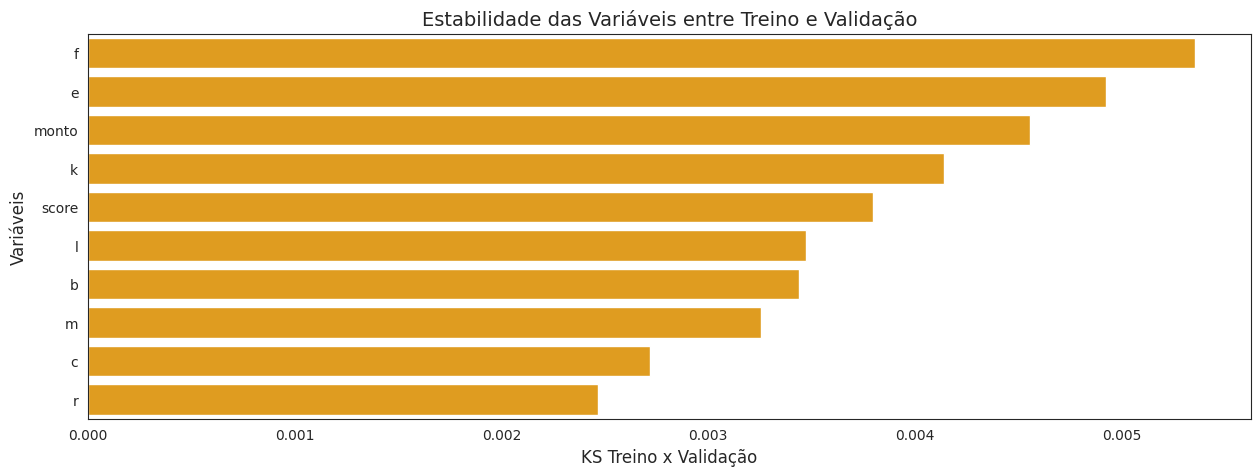

In [71]:
feature_stability_plot(df_train, df_valid, numerical_features, 'ks')

Todas as variáveis apresentam KS < 0.8, mostrando que não tem grande diferença entre a base de treino e a de validação. Com isso vamos seguir com todas as variáveis, caso alguma variável demonstrasse instabilidade por esse teste seria possível remove-la para evitar problemas de variação de performance do modelo.  

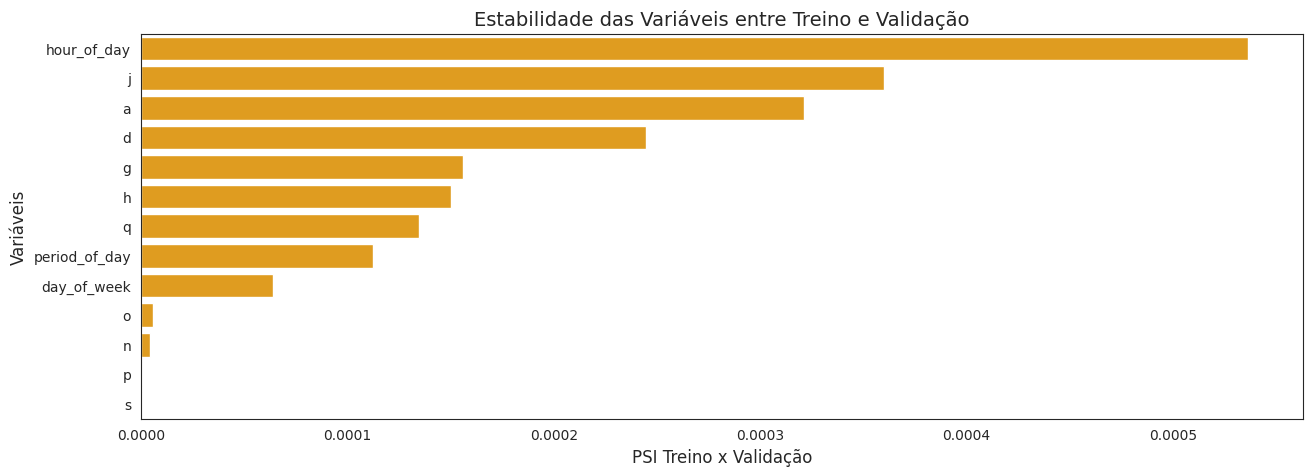

In [72]:
feature_stability_plot(ord_enc.transform(df_train), ord_enc.transform(df_valid), categorical_features, 'psi')

Avaliando o PSI das variáveis categóricas também não temos nenhuma variável alarmante com PSI >= 0.2, vamos manter todas as variáveis.

### Correlação com Target

In [73]:
df_corr_pearson_uni = df_train[numerical_features + ['fraude']].corr()['fraude'].drop('fraude')

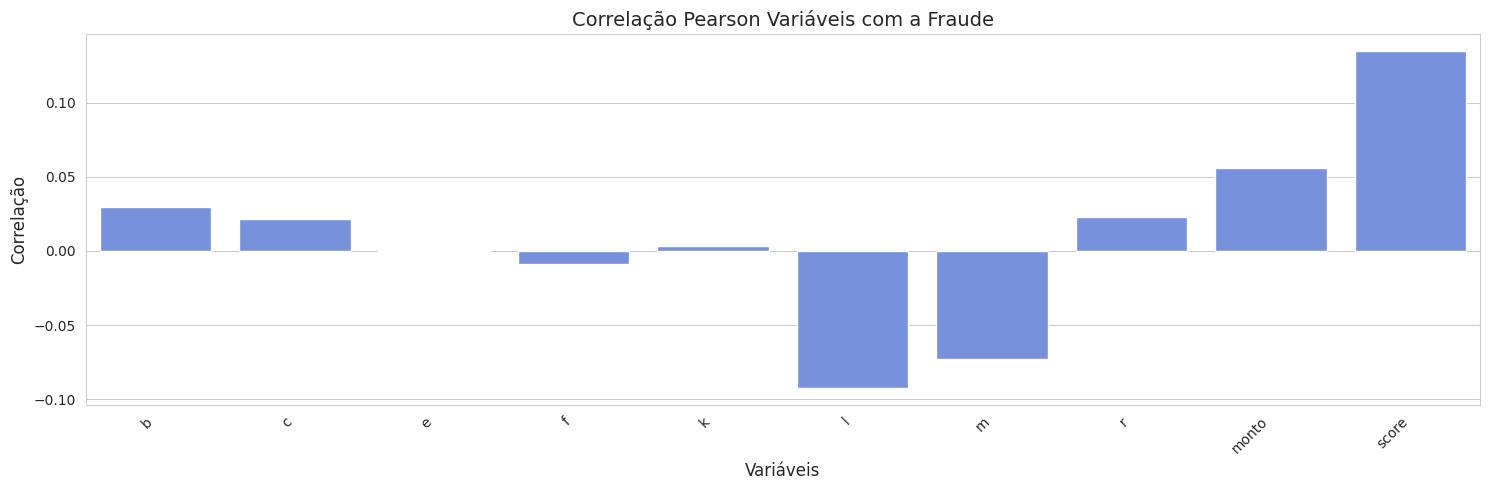

In [74]:
sns.set_style('whitegrid')

plt.figure(figsize=(15, 5))
sns.barplot(x=df_corr_pearson_uni.index, y=df_corr_pearson_uni.values)

plt.title(f'Correlação Pearson Variáveis com a Fraude', fontsize=14)
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Correlação', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

Avaliando relações lineares entre as variáveis explicativas e a variável resposta, não temos nenhuma variável super correlacionada, não demonstrando nenhum possível leak. Temos algumas variáveis com baixissima correlação com a variável resposta, porêm vamos mante-las visto que vamos utilizar técnicas de modelagem que avaliam relações não lineares e multivariadas.  

In [75]:
df_corr_spearman_uni = ord_enc.fit_transform(df_train[categorical_features + ['fraude']]).corr(method='spearman')['fraude'].drop('fraude')

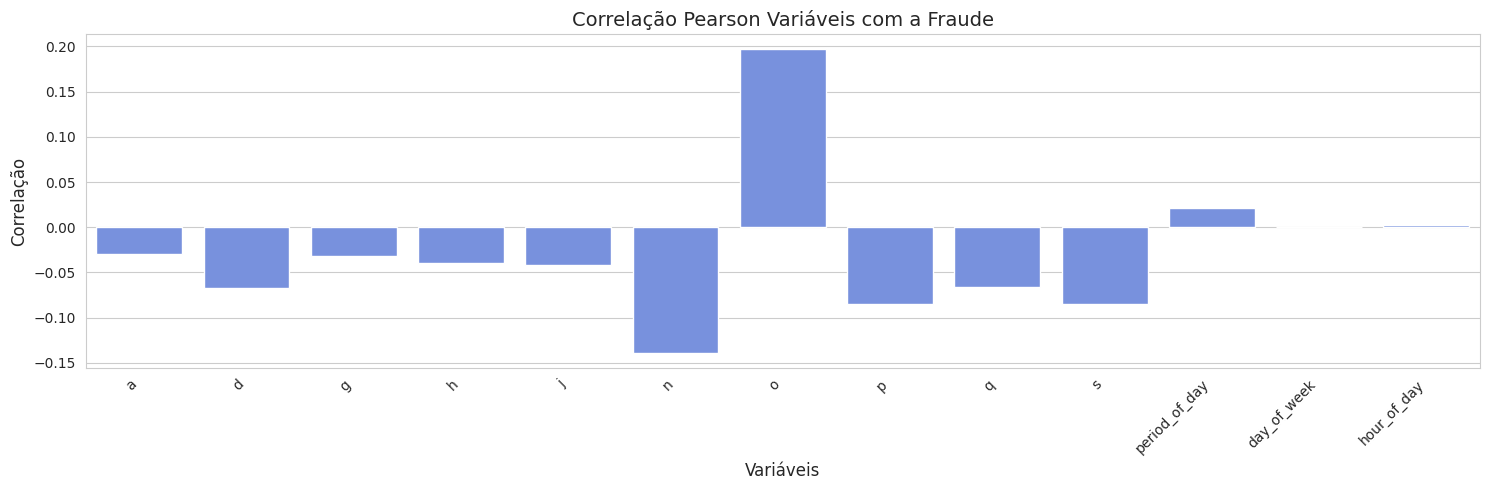

In [76]:
sns.set_style('whitegrid')

plt.figure(figsize=(15, 5))
sns.barplot(x=df_corr_spearman_uni.index, y=df_corr_spearman_uni.values)

plt.title(f'Correlação Pearson Variáveis com a Fraude', fontsize=14)
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Correlação', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

Avaliando a correlação das variáveis categóricas com a variável resposta, também não encontramos nenhum sinal de possível leak, vamos manter todas as variáveis para modelagem.  

### Análise Bivariada

#### Correlação Numéricas

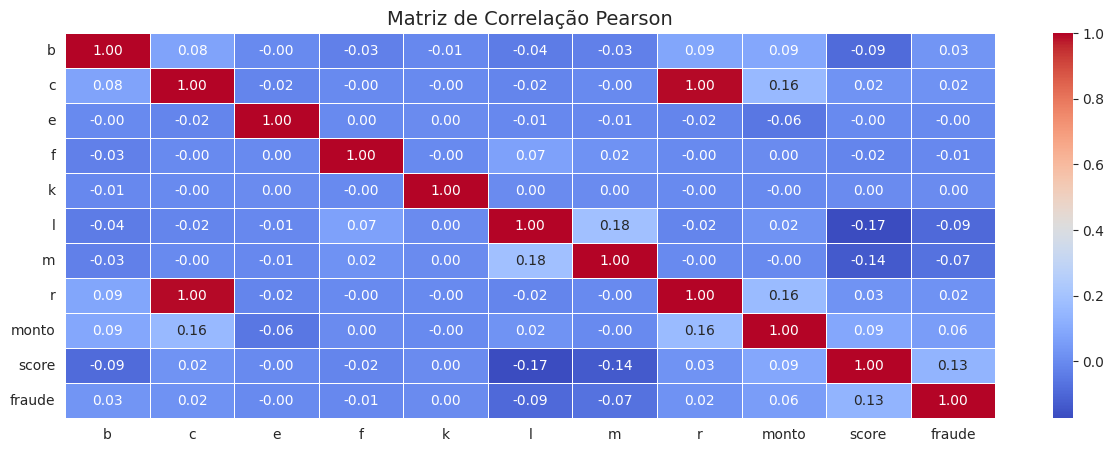

In [77]:
corr_matrix = df_train[numerical_features + ['fraude']].corr()

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

plt.title('Matriz de Correlação Pearson', fontsize=14)
plt.show()

#### Analise 'r' - 'c'

Avaliando as variáveis numéricas, o que nos chama atenção são as variáveis r e c estão 100% correlacionadas, vamos olhar no detalhe para entender se são a mesma variável

In [78]:
df_train[['r', 'c']].describe().T

count           mean            std   min       25%       50%  \
r  156055.0  250586.840806  755566.418461  0.00  12597.00  61477.00   
c  156055.0  221768.654110  758779.966860  0.16  12597.28  43048.13   

         75%          max  
r  260445.00  13878743.00  
c  116491.07  13878743.71

A distribuição das variáveis é um pouco diferente, vamos olhar alguns casos para entender

In [79]:
df_train[['r', 'c']].head(20).T

0          1        2        3         4          5          6   \
r  94436.00  242549.00  5728.00  7121.00  40143.00  121926.00  440434.00   
c  94436.24  242549.09  5728.68  7121.78  40143.12  121926.06  440434.49   

        7       8          9         10        11         12        13  \
r  6555.00  706.00  260445.00  54391.00  25321.00  260445.00  48974.00   
c  6555.99  706.47   43048.13  54391.51  25321.91   43048.13  48974.84   

           14      15         16         17         18        19  
r  4272698.00  1344.0  137003.00  281577.00  128671.00  88436.00  
c  4272698.03  1344.3  137003.67  281577.49  128671.77  88436.52

Alguns valores estão arredondados e outros parecem estar totalmente trocados, vamos arredondar os valores e avaliar o que continua diferente

In [80]:
df_train['c_new'] = np.floor(df_train['c'])
df_train['r_dif_c'] = df_train[['r', 'c_new']].apply(lambda x: 1 if x['r'] != x['c_new'] else 0, axis=1)
df_train[df_train['r_dif_c'] == 1][['r', 'c', 'c_new']].head(2)

r         c    c_new
9   260445  43048.13  43048.0
12  260445  43048.13  43048.0

In [81]:
df_train[df_train['r_dif_c'] == 1][['r', 'c', 'c_new']].nunique()

r        1
c        1
c_new    1
dtype: int64

Tirando os arredondamentos, o que esta acontecendo é que tem 1 valor que esta sendo trocado por outro entre as duas variáveis (250445 por 43515.6), para decidir qual usar vamos avaliar a bad rate entre esses dois números, e escolher aquele que mais se adequa na distribuição, mesmo que a técnica leve em consideração a não linearidade isso pode nos ajudar na explicabilidade.

In [82]:
print(f"R - Bad rate categoria: {df_train[df_train['r'] == 260445]['fraude'].mean():.5f}, Bad rate > categoria: {df_train[df_train['r'] > 260445]['fraude'].mean():.5f}")
print(f"C - Bad rate categoria: {df_train[df_train['c'] == 42638.24]['fraude'].mean():.5f}, Bad rate > categoria: {df_train[df_train['c'] > 42638.24]['fraude'].mean():.5f}")

R - Bad rate categoria: 0.03572, Bad rate > categoria: 0.03839
C - Bad rate categoria: 0.00000, Bad rate > categoria: 0.03211


Com o valor acima e observando o gráfico de correlação de pearson, sabemos que a variável C e R tem correlação levemente positiva com a variável resposta, então vamos utilizar a variável R, visto que o valor esta melhor posicionado na distribuição.

### Correlação Categóricas

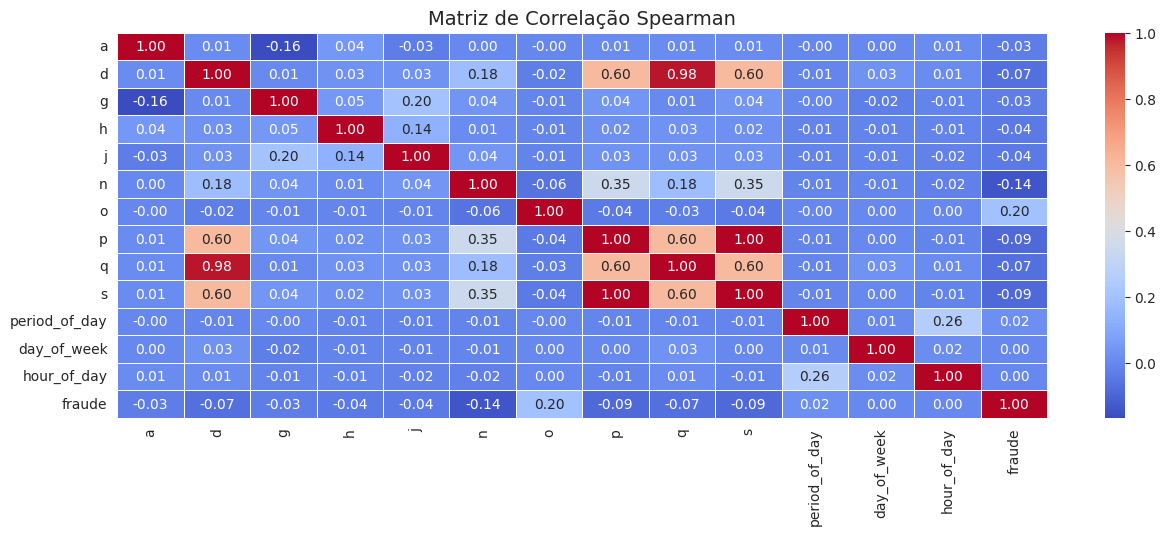

In [83]:
corr_matrix = ord_enc.fit_transform(df_train[categorical_features + ['fraude']]).corr(method='spearman')

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

plt.title('Matriz de Correlação Spearman', fontsize=14)
plt.show()

Nas variáveis categóricas temos dois pares de variáveis altamente correlacionadas, 'd' - 'q' e 'p' - 's', também temos 'p' - 'd' e 's' - 'd' e 'q' - 's' com uma valor relevante e vamos analisar.

#### Analise 'd' - 'q'

In [84]:
df_train[['d', 'q']].describe().T

count       mean        std  min   25%    50%    75%   max
d  156055.0  21.564737  19.981830 -2.0  3.00  14.00  49.00  51.0
q  156055.0   0.418550   0.405937 -1.0  0.04   0.28   0.98   1.0

Observando a distribuição é possível notar que q é igual a d * ~50, dado isso vamos seguir removendo 'q' e manter 'd' com número inteiros.  

#### Análise 'p' - 's'

In [85]:
ord_enc.fit_transform(df_train)[['p', 's']].describe().T

count       mean        std  min  25%    50%    75%    max
p  156055.0   0.562936   0.496025  0.0  0.0    1.0    1.0    1.0
s  156055.0  56.293614  49.602482  0.0  0.0  100.0  100.0  100.0

In [86]:
df_train[['p', 's']].head().T

0  1  2  3    4
p  N  N  N  N    Y
s  0  0  0  0  100

As duas variáveis também são a mesma variável, uma em formato de string e outra numérica, vamos manter 's' por ser numérica.  

#### Análise 's' - 'd'

In [87]:
df_train[['s', 'd']].describe().T

count       mean        std  min  25%    50%    75%    max
s  156055.0  56.293614  49.602482  0.0  0.0  100.0  100.0  100.0
d  156055.0  21.564737  19.981830 -2.0  3.0   14.0   49.0   51.0

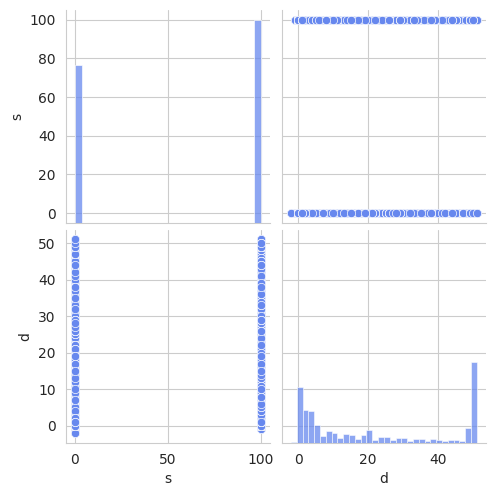

In [88]:
sns.pairplot(df_train[['s', 'd']])

São variáveis totalmente diferentes, 's' é binária e d tem maior cardinalidade, vamos seguir mantendo as duas

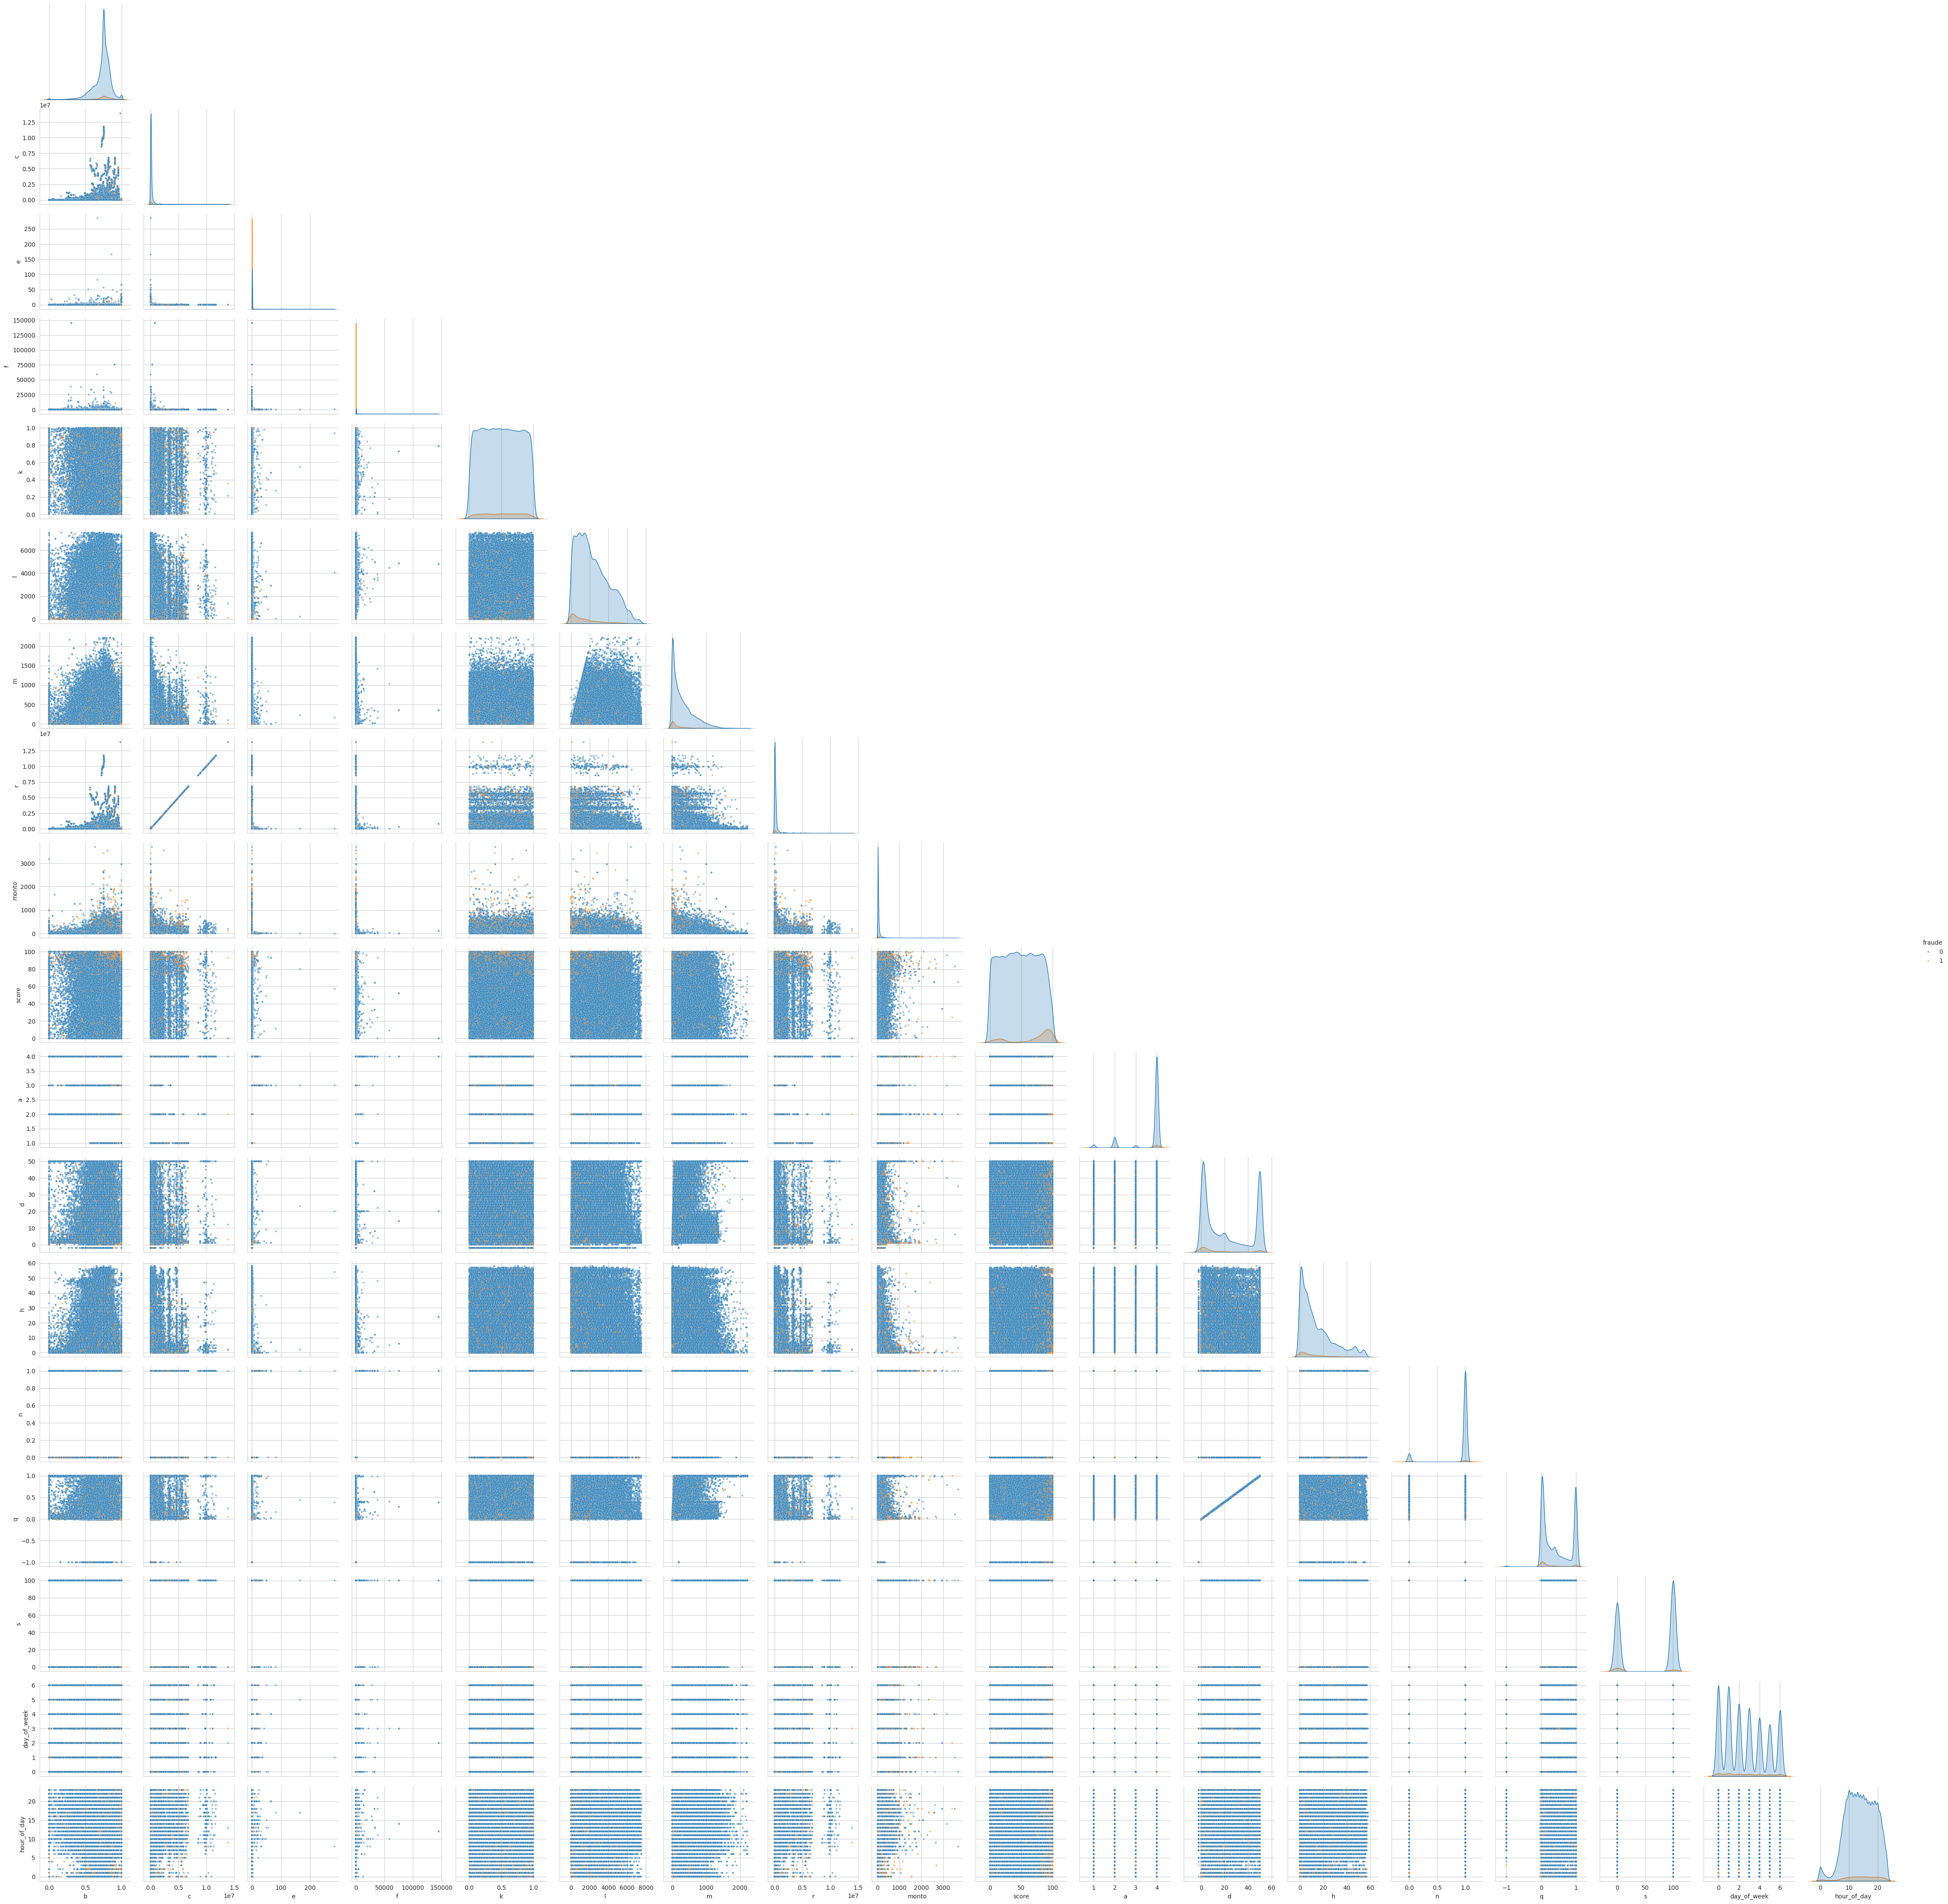

In [ ]:
sns.pairplot(data=df_train[numerical_features + categorical_features + ['fraude']], 
             hue='fraude', corner=True, plot_kws={'s':10, 'alpha':0.5})

Analisando a relação entre duas variáveis não é possível notar nenhuma combinação a olho nú, capaz de separar com grande precisão os dados de fraude e não fraude.  
Resalto apenas o score, que consegue realaizar uma separação, acumulando mais fraudes no score próximo de 100, que já foi observado na parte de analise do baseline.  

### Conclusão EDA

Por fim, após analisaar algumas variáveis com relação a estabilidade e interação com outras e com a variável resposta, descartamos algumas ficando com as variáveis explicativas abaixo:  
- b
- e
- f
- k
- l
- m
- r
- monto
- a
- d
- g
- h
- j
- n
- o
- s
- period_of_day
- day_of_week
- hour_of_day

Não vamos utilizar a variável score pois a ideia é criar um novo score que possa complementa-lo ou substitui-lo.
Também tiveram algumas variáveis que foram deixadas de fora, como: i e j.

A variável i aparenta ser a descrição do produto comprado, podemos utiliza-la para tentar prever se a transação é fraudulenta fazendo o embedding dessa coluna e usando como variável para o modelo, em casos de marketplace isso indicaria conivência por parte do anunciante.  

## Feature Store

Após a análise exploratória tive algumas ideias para criação de novas variáveis, então nessa etapa serão criadas variáveis que não se encontram no dataset/payload e que podem ser construídas a partir de estruturas de feature stores.  

Nessa etapa será criado 1 *feature groups*:  
- Perfil Categoria Produto últimos 7 dias (as variáveis de fraude não serão tão realistas, visto que a maturação da fruade esta sendo desconsiderada)

A ideia desse feature group é trazer informações históricas dos produtos condensados.  

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Data

In [2]:
df_train = pd.read_parquet('../data/processed/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/processed/fraud_dataset_v2_valid.parquet.gzip')
df_test = pd.read_parquet('../data/processed/fraud_dataset_v2_test.parquet.gzip')

In [4]:
df = pd.concat([
    df_train,
    df_valid,
    df_test
], ignore_index=True).reset_index(drop=True)

In [6]:
df.head(2)

a       b          c     d         e     f   g   h  \
0  4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1  4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   

        l      m  n     o  p     q       r  s               fecha   monto  \
0   240.0  102.0  1  NULO  N  0.40   94436  0 2020-03-27 11:51:16    5.64   
1  1779.0   77.0  1  NULO  N  0.06  242549  0 2020-03-25 18:13:38  339.32   

   score  fraude       ymd  day_of_week  hour_of_day period_of_day  
0   66.0       0  20200327            4           11       morning  
1   95.0       0  20200325            2           18       evening

### Feature Groups

#### Perfil Estabelecimento

In [7]:
class FeatureStore:

    key = 'j'
    date_ref = 'ymd'
    window = 7
    delay = 1
    name = None
    path_to_save = None

    def __repr__(self):
        return f'I am {self.name}'

    def save(self):
        self.data.to_parquet(
            f'{self.path_to_save}/{self.name}.parquet.gzip',
            compression='gzip',
            index=False
        )

    def process(self, X):
        print('Hi! Implement this method!')

    def merge(self, X):
        return X.merge(
            self.data,
            how='left',
            on=[self.key, self.date_ref]
        )

class FeatureStoreCategoryProfile(FeatureStore):

    name = 'FeatureStoreCategoryProfile'
    path_to_save = '../data/feature_store'

    def process(self, df):
        # Fill dataset with all possible dates
        dt_init = str(df['ymd'].min())
        dt_end = str(df['ymd'].max())
        all_dates = pd.date_range(start=datetime.strptime(dt_init, '%Y%m%d'), end=datetime.strptime(dt_end, '%Y%m%d'))

        unique_clients = df['j'].unique()
        df_clients_with_all_dates = pd.MultiIndex.from_product([unique_clients, all_dates], names=['j', 'ymd']).to_frame(index=False)
        df_clients_with_all_dates['ymd'] = df_clients_with_all_dates['ymd'].dt.strftime('%Y%m%d').astype(int)

        df_processed = df_clients_with_all_dates.merge(df[['j', 'ymd', 'monto', 'fraude']], on=['j', 'ymd'], how='left')
        
        # Create new Features
        df_processed['monto_fraude'] = df_processed['monto'] * df_processed['fraude']

        # Aggregate
        self.data = (
            df_processed
            .groupby(['j', 'ymd'])
            .agg({
                'monto' : ['sum', 'count'],
                'monto_fraude' : 'sum',
                'fraude' : 'sum'
            })
            .sort_values(by=['j', 'ymd'], ascending=True)
            .reset_index()
            .groupby('j')
            .rolling(window=self.window, min_periods=1)
            .agg({
                ('ymd', '') : 'max',
                ('monto', 'sum') : 'sum',
                ('monto', 'count') : 'sum',
                ('monto_fraude', 'sum') : 'sum',
                ('fraude', 'sum') : 'sum'
            })
            .reset_index(level=0)
        )
        # Fix date ref, to not include current day
        self.data['ymd'] += self.delay
        self.data.columns = ['j', 'ymd', 'vl_cat_last7d', 'qty_cat_last7d', 'vl_fraud_cat_last7d', 'qty_fraud_cat_last7d']

        # New features to this feature store
        self.data['br_vl_cat_last7d'] = np.nan_to_num(self.data['vl_fraud_cat_last7d'] / self.data['vl_cat_last7d'], 
                                                       nan=0, posinf=1e9, neginf=-1e9)
        self.data['br_qty_cat_last7d'] = np.nan_to_num(self.data['qty_fraud_cat_last7d'] / self.data['qty_cat_last7d'], 
                                                       nan=0, posinf=1e9, neginf=-1e9)


In [8]:
fs = FeatureStoreCategoryProfile()

In [9]:
a = fs.process(df)

/tmp/ipykernel_2871/3487308518.py:62: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .rolling(window=self.window, min_periods=1)


In [10]:
df[df['j'] == 'cat_0005972'].sort_values('ymd', ascending=True)[['monto', 'ymd']]

monto       ymd
83720    2.22  20200309
64060    5.63  20200313
150567   9.36  20200313
176557   9.36  20200313
8885     2.62  20200324

In [11]:
fs.data.head(20)

j         ymd  vl_cat_last7d  qty_cat_last7d  \
0   cat_0005972  20200309.0           0.00             0.0   
1   cat_0005972  20200310.0           2.22             1.0   
2   cat_0005972  20200311.0           2.22             1.0   
3   cat_0005972  20200312.0           2.22             1.0   
4   cat_0005972  20200313.0           2.22             1.0   
5   cat_0005972  20200314.0          26.57             4.0   
6   cat_0005972  20200315.0          26.57             4.0   
7   cat_0005972  20200316.0          26.57             4.0   
8   cat_0005972  20200317.0          24.35             3.0   
9   cat_0005972  20200318.0          24.35             3.0   
10  cat_0005972  20200319.0          24.35             3.0   
11  cat_0005972  20200320.0          24.35             3.0   
12  cat_0005972  20200321.0           0.00             0.0   
13  cat_0005972  20200322.0           0.00             0.0   
14  cat_0005972  20200323.0           0.00             0.0   
15  cat_0005972  20200324.0           0.00             0.0   
16  cat_0005972  20200325.0           2.62             1.0   
17  cat_0005972  20200326.0           2.62             1.0   
18  cat_0005972  20200327.0           2.62             1.0   
19  cat_0005972  20200328.0           2.62             1.0   

    vl_fraud_cat_last7d  qty_fraud_cat_last7d  br_vl_cat_last7d  \
0                  0.00                   0.0               0.0   
1                  0.00                   0.0               0.0   
2                  0.00                   0.0               0.0   
3                  0.00                   0.0               0.0   
4                  0.00                   0.0               0.0   
5                  0.00                   0.0               0.0   
6                  0.00                   0.0               0.0   
7                  0.00                   0.0               0.0   
8                  0.00                   0.0               0.0   
9                  0.00                   0.0               0.0   
10                 0.00                   0.0               0.0   
11                 0.00                   0.0               0.0   
12                 0.00                   0.0               0.0   
13                 0.00                   0.0               0.0   
14                 0.00                   0.0               0.0   
15                 0.00                   0.0               0.0   
16                 2.62                   1.0               1.0   
17                 2.62                   1.0               1.0   
18                 2.62                   1.0               1.0   
19                 2.62                   1.0               1.0   

    br_qty_cat_last7d  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
5                 0.0  
6                 0.0  
7                 0.0  
8                 0.0  
9                 0.0  
10                0.0  
11                0.0  
12                0.0  
13                0.0  
14                0.0  
15                0.0  
16                1.0  
17                1.0  
18                1.0  
19                1.0

In [12]:
fs.save()

In [13]:
fs.merge(df)[['j', 'ymd', 'qty_cat_last7d', 'vl_cat_last7d']]

j       ymd  qty_cat_last7d  vl_cat_last7d
0       cat_8d714cd  20200327           129.0        4710.12
1       cat_e9110c5  20200325            11.0        2204.78
2       cat_6c4cfdc  20200402           603.0        9877.30
3       cat_5d6059e  20200322           125.0        5873.41
4       cat_5d79fb9  20200311             2.0           4.98
...             ...       ...             ...            ...
275283  cat_fa01313  20200415            51.0        3436.50
275284  cat_960e53d  20200420           193.0        4155.61
275285  cat_20ab7f2  20200421             2.0          59.17
275286  cat_ad042e7  20200417            11.0         110.02
275287  cat_3f81bbe  20200412            31.0        1664.61

[275288 rows x 4 columns]

In [14]:
df[(df['j'] == 'cat_0cd53cb') & (df['ymd'] < 20200309)]['monto'].agg(['count', 'sum'])

count      31.00
sum      1227.94
Name: monto, dtype: float64

In [15]:
for df_, group in [(df_train, 'train'), (df_valid, 'valid'), (df_test, 'test')]:
    df_ = fs.merge(df_)

    df_.to_parquet(f'../data/enrich/fraud_dataset_v2_{group}.parquet.gzip', 
                   compression='gzip', index=False)

Variável criada com sucesso e validada, foram implementadas duas classes para facilitar desenvolvimentos futuros, podendo herdar a classe FeatureStore e realizar apenas implementações específicas

## Feature Selection

Mesmo com um problema com poucas variáveis vamos realizar um método de seleção de features.  
Vamos utilizar como forma de seleção o algoritmo RandomForest com os parametros a seguir:
- `n_estimators=100` : Quantidade razoaável de árvores  
- `criterion='gini'` : Eficiência computacional vs entropia  
- `max_depth=5` : Quantidade razoável de nós  
- `max_features='sqrt` : Oportunidade de interação de diferentes features  
- `class_weight='balanced'` : Problema desbalanceado, dando maior peso para classes minoritárias  
A escolha do algoritmo se deve ao fato de ser uma forma simples de avaliar a importância de cada uma das variáveis, avaliando um método de árvore (mesmo que será utilizado no algoritmo final) e selecioanando as variáveis, dando oportunidade para elas aparecerem em diferentes árvores interagindo com diferentes variáveis.  

No meio das variáveis serão colocadas 4 variáveis aleatórias, 2 categóricas (baixa cardinalidade) e 2 continuas.  
As variáveis selecionadas serão aquelas que se mantiverem acima da primeira aleatória no ranking de importância por `ganho de informação` ou que acumularem juntas 95% de importância (valem testes para definir esses valores).  

(método parecido com Boruta, porém computacionalmente mais rápido)

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from feature_engine.encoding import OrdinalEncoder

### Data

In [17]:
df_train = pd.read_parquet('../data/enrich/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/enrich/fraud_dataset_v2_valid.parquet.gzip')

In [18]:
for i in range(1,3):
    # replicability
    np.random.seed(i)
    df_train[f'___random_cat_{i}___'] = np.random.randint(0, i*25, size=df_train.shape[0])

    np.random.seed(i)
    df_train[f'___random_con_{i}___'] = np.random.uniform(0, 1000000, size=df_train.shape[0])

In [20]:
df_train.head(2)

a       b          c     d         e     f   g   h  \
0  4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1  4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   

        l      m  n     o  p     q       r  s               fecha   monto  \
0   240.0  102.0  1  NULO  N  0.40   94436  0 2020-03-27 11:51:16    5.64   
1  1779.0   77.0  1  NULO  N  0.06  242549  0 2020-03-25 18:13:38  339.32   

   score  fraude       ymd  day_of_week  hour_of_day period_of_day  \
0   66.0       0  20200327            4           11       morning   
1   95.0       0  20200325            2           18       evening   

   vl_cat_last7d  qty_cat_last7d  vl_fraud_cat_last7d  qty_fraud_cat_last7d  \
0        4710.12           129.0                51.47                   3.0   
1        2204.78            11.0                 0.00                   0.0   

   br_vl_cat_last7d  br_qty_cat_last7d  ___random_cat_1___  \
0          0.010928           0.023256                   5   
1          0.000000           0.000000                  11   

   ___random_con_1___  ___random_cat_2___  ___random_con_2___  
0       417022.004703                  40       435994.902142  
1       720324.493442                  15        25926.231828

### Feature Selection

In [21]:
hard_remove = ['c', 'p', 'q', 'fecha', 'i', 'score', 'fraude', 'ymd']

In [22]:
ord_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=df_train.drop(columns=hard_remove).select_dtypes(include=['object']).columns.tolist()
).fit(df_train)

In [23]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5,
                            max_features='sqrt', class_weight='balanced', random_state=777, n_jobs=-1)

In [24]:
rf.fit(ord_enc.transform(df_train).drop(columns=hard_remove), df_train['fraude'])

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1,
                       random_state=777)

In [25]:
df_importance = pd.DataFrame({
    'feature': rf.feature_names_in_,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
df_importance['importance_cumsum'] = df_importance['importance'].cumsum()
df_importance

feature  importance  importance_cumsum
0                      o    0.374729           0.374729
1                      f    0.113400           0.488128
2                      n    0.104121           0.592250
3                      a    0.094201           0.686450
4                      l    0.089139           0.775590
5                      m    0.053568           0.829158
6                      s    0.030943           0.860101
7      br_qty_cat_last7d    0.028513           0.888614
8                      d    0.018321           0.906936
9       br_vl_cat_last7d    0.017104           0.924039
10  qty_fraud_cat_last7d    0.014372           0.938411
11                     h    0.013969           0.952380
12   vl_fraud_cat_last7d    0.010334           0.962714
13                     b    0.008988           0.971702
14                 monto    0.006546           0.978247
15                     r    0.005253           0.983500
16                     g    0.003001           0.986501
17           hour_of_day    0.002809           0.989310
18                     j    0.002550           0.991860
19         vl_cat_last7d    0.002000           0.993860
20         period_of_day    0.001965           0.995824
21        qty_cat_last7d    0.001600           0.997424
22                     e    0.001173           0.998597
23                     k    0.000387           0.998984
24    ___random_con_2___    0.000361           0.999345
25    ___random_cat_2___    0.000228           0.999573
26    ___random_cat_1___    0.000218           0.999791
27    ___random_con_1___    0.000135           0.999926
28           day_of_week    0.000074           1.000000

Considerando o critério de acumular 95% de importância, temos 12 variáveis selecionadas:  
- o  
- f  
- n  
- l  
- a  
- m  
- s  
- br_qty_cat_last7d  
- d  
- br_vl_cat_last7d  
- qty_fraud_cat_last7d  
- h  
- vl_fraud_cat_last7d  

Interessante o valor da transação não ter entredo como variável, poderemos utilizar ele no futuro no sample weight do lightgbm para dar maior peso a transações de valor alto.  

## Encoding

Nessa etapa vamos realizar o encoding das variáveis não numéricas, para conseguir passar os dados pelo modelo.  
Como vamos utilizar um modelo baseado em árvores, vamos utilizar um ordinal encoder, visto que o modelo consegue capturar não linearidade.  
Além dos encoders vamos criar todos os artefatos binários necessários para montar a pipeline do modelo.    


In [43]:
import pandas as pd
from feature_engine.encoding import OrdinalEncoder
import yaml
import pickle

import sys
sys.path.append('../')
from src.utils.transformers import Selector, FeatureEngineering, FixFeaturesMissing, FixFeaturesType
from src.utils.modeling import apply_encoders

# Data

In [32]:
df_train = pd.read_parquet('../data/enrich/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/enrich/fraud_dataset_v2_valid.parquet.gzip')
df_test = pd.read_parquet('../data/enrich/fraud_dataset_v2_test.parquet.gzip')

In [33]:
support_features = ['o','f','n','l','a','m','s','br_qty_cat_last7d',
                    'd','br_vl_cat_last7d','qty_fraud_cat_last7d','h',
                    'vl_fraud_cat_last7d']

In [34]:
config_features = yaml.safe_load(open('../src/data/config/features.yml', 'r'))

In [35]:
config_features

{'temporal_feature': 'fecha',
 'target_feature': 'fraude',
 'fix_type_map': {'datetime[64]': ['fecha']},
 'fix_missing_map': {'d': -2, 'g': 'NULO', 'o': 'NULO', 'q': -1},
 'fix_missing_numeric_features': ['b', 'c', 'f', 'l', 'm'],
 'hard_remove_features': ['c',
  'p',
  'q',
  'fecha',
  'i',
  'score',
  'fraude',
  'ymd']}

### Encoding

In [38]:
ord_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=df_train[support_features].select_dtypes(include=['object', 'string']).columns.tolist()
).fit(df_train)

In [39]:
ord_enc.transform(df_train).head(2)

a       b          c     d         e     f   g   h  \
0  4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1  4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   

                                                   i            j         k  \
0  Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1  Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   

        l      m  n  o  p     q       r  s               fecha   monto  score  \
0   240.0  102.0  1  0  N  0.40   94436  0 2020-03-27 11:51:16    5.64   66.0   
1  1779.0   77.0  1  0  N  0.06  242549  0 2020-03-25 18:13:38  339.32   95.0   

   fraude       ymd  day_of_week  hour_of_day period_of_day  vl_cat_last7d  \
0       0  20200327            4           11       morning        4710.12   
1       0  20200325            2           18       evening        2204.78   

   qty_cat_last7d  vl_fraud_cat_last7d  qty_fraud_cat_last7d  \
0           129.0                51.47                   3.0   
1            11.0                 0.00                   0.0   

   br_vl_cat_last7d  br_qty_cat_last7d  
0          0.010928           0.023256  
1          0.000000           0.000000

In [40]:
selector = Selector(support_features).fit(df)
fix_type = FixFeaturesType(config_features['fix_type_map']).fit(df)
fix_missing = FixFeaturesMissing(config_features['fix_missing_numeric_features'], 
                                 config_features['fix_missing_map']).fit(df)
feature_engineering = FeatureEngineering().fit(df)

In [41]:
pickle.dump(ord_enc, open('../model/encoders/ordinal_encoder.pkl', 'wb'))
pickle.dump(selector, open('../model/encoders/selector.pkl', 'wb'))
pickle.dump(fix_type, open('../model/encoders/fix_type.pkl', 'wb'))
pickle.dump(fix_missing, open('../model/encoders/fix_missing.pkl', 'wb'))
pickle.dump(feature_engineering, open('../model/encoders/feature_engineering.pkl', 'wb'))

In [45]:
for df_, group in [(df_train, 'train'), (df_valid, 'valid'), (df_test, 'test')]:
    df_ = apply_encoders(df_, [ord_enc])

    df_.to_parquet(f'../data/encoded/fraud_dataset_v2_{group}.parquet.gzip', 
                   compression='gzip', index=False)

## Tune

Trabalhando com um algoritmo de boosting temos diversos parametros que podem ser alterados, mudando a performance do modelo, nesta etapa utilizaremos a biblioteca `optuna` para tunagem dos hiperparametros. 

In [46]:
import pandas as pd
import lightgbm as lgbm
import optuna
import pickle

import sys
sys.path.append('../')

from src.utils.modeling import objective

/home/diego/meli-fraud/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [47]:
df_train = pd.read_parquet('../data/encoded/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/encoded/fraud_dataset_v2_valid.parquet.gzip')

In [48]:
selector = pickle.load(open('../model/encoders/selector.pkl', 'rb'))

# Tune

In [49]:
sampler = optuna.samplers.TPESampler(seed=777)
study = optuna.create_study(direction='maximize', sampler=sampler)

# Don't use n_jobs to keep replicability
study.optimize(lambda trial: objective(trial,
                                       selector.transform(df_train), 
                                       df_train['fraude'],
                                       [(selector.transform(df_valid), 
                                         df_valid['fraude'])]), n_trials=15, n_jobs=1)

print("Best parms:", study.best_params)

[I 2025-02-14 05:54:11,919] A new study created in memory with name: no-name-37843412-b56a-4a33-8de6-4a3c89f3e1ff


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5


[I 2025-02-14 05:54:13,265] Trial 0 finished with value: 0.5861140648174852 and parameters: {'n_estimators': 160, 'learning_rate': 0.027965164266499885, 'num_leaves': 18, 'max_depth': 6, 'min_child_samples': 85}. Best is trial 0 with value: 0.5861140648174852.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:17,027] Trial 1 finished with value: 0.6893175229774109 and parameters: {'n_estimators': 480, 'learning_rate': 0.11853616726044315, 'num_leaves': 118, 'max_depth': 5, 'min_child_samples': 66}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:18,180] Trial 2 finished with value: 0.5761118776582187 and parameters: {'n_estimators': 130, 'learning_rate': 0.013113110332485146, 'num_leaves': 93, 'max_depth': 5, 'min_child_samples': 99}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:20,892] Trial 3 finished with value: 0.6451612135677709 and parameters: {'n_estimators': 350, 'learning_rate': 0.10164140628090507, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 40}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:22,281] Trial 4 finished with value: 0.5728841099832723 and parameters: {'n_estimators': 190, 'learning_rate': 0.01885377534053743, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 63}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:25,388] Trial 5 finished with value: 0.6213544713294462 and parameters: {'n_estimators': 460, 'learning_rate': 0.08303666629012729, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 83}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:27,424] Trial 6 finished with value: 0.6243531497214878 and parameters: {'n_estimators': 190, 'learning_rate': 0.058004363720065344, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 56}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5


[I 2025-02-14 05:54:28,861] Trial 7 finished with value: 0.6405975710464886 and parameters: {'n_estimators': 100, 'learning_rate': 0.05945045816068611, 'num_leaves': 136, 'max_depth': 9, 'min_child_samples': 16}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:31,020] Trial 8 finished with value: 0.6307252079056357 and parameters: {'n_estimators': 220, 'learning_rate': 0.08017390503781506, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 78}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:32,723] Trial 9 finished with value: 0.6104880210501443 and parameters: {'n_estimators': 170, 'learning_rate': 0.06668632616374084, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 81}. Best is trial 1 with value: 0.6893175229774109.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:39,797] Trial 10 finished with value: 0.9993069071473926 and parameters: {'n_estimators': 480, 'learning_rate': 0.2995116389699143, 'num_leaves': 134, 'max_depth': 10, 'min_child_samples': 38}. Best is trial 10 with value: 0.9993069071473926.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:47,296] Trial 11 finished with value: 0.9986368032651709 and parameters: {'n_estimators': 500, 'learning_rate': 0.24049011604011356, 'num_leaves': 147, 'max_depth': 9, 'min_child_samples': 36}. Best is trial 10 with value: 0.9993069071473926.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:54:54,033] Trial 12 finished with value: 0.9988209036631188 and parameters: {'n_estimators': 400, 'learning_rate': 0.25340627158690127, 'num_leaves': 150, 'max_depth': 10, 'min_child_samples': 34}. Best is trial 10 with value: 0.9993069071473926.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5


[I 2025-02-14 05:54:57,453] Trial 13 finished with value: 0.9827307059490178 and parameters: {'n_estimators': 390, 'learning_rate': 0.2958005329746376, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 10 with value: 0.9993069071473926.


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-02-14 05:55:07,113] Trial 14 finished with value: 0.9938395817769531 and parameters: {'n_estimators': 410, 'learning_rate': 0.17048598990663696, 'num_leaves': 148, 'max_depth': 10, 'min_child_samples': 35}. Best is trial 10 with value: 0.9993069071473926.


Best parms: {'n_estimators': 480, 'learning_rate': 0.2995116389699143, 'num_leaves': 134, 'max_depth': 10, 'min_child_samples': 38}


In [50]:
study.best_params

{'n_estimators': 480,
 'learning_rate': 0.2995116389699143,
 'num_leaves': 134,
 'max_depth': 10,
 'min_child_samples': 38}

## Train

Enfim chegamos na etapa de treinamento do modelo, para esse problema vamos utilizar um modelo de boosting. Esse tipo de modelo foi escolhido devido as características encontradas no problema:  
- Problema desbalanceado, modelos de boosting conseguem se adequar bem a esse tipo de problema devido a classificação errada incorporar um peso entre as iterações.  
- É um modelo robusto e de fácil treinamento.  
- Por mais que seja um modelo "caixa-preta", é possível trazer explicabilidade através de bibliotecas como shap e lime. 

In [90]:
import pandas as pd
import lightgbm as lgbm
import yaml
import pickle
import sys
from sklearn.metrics import roc_auc_score

sys.path.append('../')

### Data

In [91]:
df_train = pd.read_parquet('../data/encoded/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/encoded/fraud_dataset_v2_valid.parquet.gzip')
df_test = pd.read_parquet('../data/encoded/fraud_dataset_v2_test.parquet.gzip')

In [92]:
params = yaml.safe_load(open('../src/model/config/hp_hparams.yml', 'r'))
selector = pickle.load(open('../model/encoders/selector.pkl', 'rb'))

# Train

In [93]:
model = lgbm.LGBMClassifier(
    verbose = 0,
    random_state = 777,
    importance_type = 'gain',
    # Early stopping changed to 2, to reduce overfitting
    early_stopping_rounds = 2,
    objective= 'binary',
    boosting_type= 'gbdt',
    n_jobs=-1,
    **params
)

In [55]:
model = model.fit(selector.transform(df_train),
                  df_train['fraude'],
                  eval_set=[(
                    selector.transform(df_valid),
                    df_valid['fraude']
                  )], 
              eval_metric='auc'
              )

[LightGBM] [Warning] early_stopping_round is set=2, early_stopping_rounds=2 will be ignored. Current value: early_stopping_round=2
[LightGBM] [Warning] early_stopping_round is set=2, early_stopping_rounds=2 will be ignored. Current value: early_stopping_round=2


In [56]:
y_pred_train = model.predict_proba(selector.transform(df_train))[:,1]
y_pred_valid = model.predict_proba(selector.transform(df_valid))[:,1]
y_pred_test = model.predict_proba(selector.transform(df_test))[:,1]

In [57]:
print(f"ROCAUC Train: {roc_auc_score(df_train['fraude'], y_pred_train)}")
print(f"ROCAUC Valid: {roc_auc_score(df_valid['fraude'], y_pred_valid)}")
print(f"ROCAUC Test: {roc_auc_score(df_test['fraude'], y_pred_test)}\n")

print(f"ROCAUC@1% Train: {roc_auc_score(df_train['fraude'], y_pred_train, max_fpr=0.01)}")
print(f"ROCAUC@1% Valid: {roc_auc_score(df_valid['fraude'], y_pred_valid, max_fpr=0.01)}")
print(f"ROCAUC@1% Test: {roc_auc_score(df_test['fraude'], y_pred_test, max_fpr=0.01)}")

ROCAUC Train: 0.8938902284997383
ROCAUC Valid: 0.8975036171985084
ROCAUC Test: 0.8784392768577745

ROCAUC@1% Train: 0.5972037724610328
ROCAUC@1% Valid: 0.5970830946349993
ROCAUC@1% Test: 0.5785103325623662


In [58]:
pickle.dump(model, open('../model/predictors/lg_model.pkl', 'wb'))

A decisão de redução do early stopping não foi tomada em cima do dataset de teste, apenas em cima do dataset de treino e validação.  
Considerando o dataset de treino e validação, temos uma queda de performance entre os dois, quando realizado um teste com early stopping = 5 a queda era ainda maior, por isso a redução de 5 para 2.  
Quando olhamos conta o dataset de teste a queda é ainda maior, vamos seguir com a analise dos resultados para entender se essa queda é constante ao longo do tempo, caso seja o ideial é voltar para etapas anteriores ao treinamento (algo normal no ciclo de modelagem do CRISP-DM).  

## Avaliação do Modelo

In [94]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, auc
from datetime import datetime
from scipy.stats import kstest
import shap

### Data

In [95]:
df_train = pd.read_parquet('../data/encoded/fraud_dataset_v2_train.parquet.gzip')
df_valid = pd.read_parquet('../data/encoded/fraud_dataset_v2_valid.parquet.gzip')
df_test = pd.read_parquet('../data/encoded/fraud_dataset_v2_test.parquet.gzip')

In [96]:
print(df_train.fraude.mean())
print(df_valid.fraude.mean())
print(df_test.fraude.mean())

0.03100739300211449
0.030991480429682677
0.028174774488196132


In [97]:
df_train = pd.concat([df_train, df_valid], ignore_index=True)
df_train['group'] = 'train'
df_test['group'] = 'test'
df = pd.concat([df_train, df_test], ignore_index=True)

# Avaliação do Modelo

In [98]:
model = pickle.load(open('../model/predictors/lgbm_model.pkl', 'rb'))

In [99]:
df['new_score'] = (model.predict_proba(df[model.feature_names_in_])[:,1]*100).round(2)
df_test['new_score'] = (model.predict_proba(df_test[model.feature_names_in_])[:,1]*100).round(2)

## Estabilidade

In [100]:
df_test['valor_fraude'] = df_test['monto'] * df_test['fraude']
df_thresholds = (
    df_test
    .groupby('new_score')
    .agg({'fraude' : ['sum', 'count'],
          'valor_fraude' : 'sum',
          'monto' : 'sum'})
    .sort_values(by='new_score', ascending=False)
    .cumsum()
    .reset_index()
)
df_thresholds.columns = ['new_score', 'qtd_fraude', 'qtd_total', 'valor_fraude', 'valor_total']
df_thresholds['fpr_#'] = (df_thresholds['qtd_total'] - df_thresholds['qtd_fraude'])/(df_thresholds['qtd_total'].max() - df_thresholds['qtd_fraude'].max())
df_thresholds['fpr_$'] = (df_thresholds['valor_total'] - df_thresholds['valor_fraude'])/(df_thresholds['valor_total'].max() - df_thresholds['valor_fraude'].max())
df_thresholds['precision_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_total']
df_thresholds['precision_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_total']
df_thresholds['recall_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_fraude'].max()
df_thresholds['recall_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_fraude'].max()
df_thresholds.iloc[0:2,:]

new_score  qtd_fraude  qtd_total  valor_fraude  valor_total  fpr_#  fpr_$  \
0      93.57           2          2         15.44        15.44    0.0    0.0   
1      92.42           3          3         23.16        23.16    0.0    0.0   

   precision_#  precision_$  recall_#  recall_$  
0          1.0          1.0  0.000806  0.000085  
1          1.0          1.0  0.001210  0.000128

In [101]:
df_test['valor_fraude'] = df_test['monto'] * df_test['fraude']
df_thresholds_old = (
    df_test
    .groupby('score')
    .agg({'fraude' : ['sum', 'count'],
          'valor_fraude' : 'sum',
          'monto' : 'sum'})
    .sort_values(by='score', ascending=False)
    .cumsum()
    .reset_index()
)
df_thresholds_old.columns = ['score', 'qtd_fraude', 'qtd_total', 'valor_fraude', 'valor_total']
df_thresholds_old['fpr_#'] = (df_thresholds_old['qtd_total'] - df_thresholds_old['qtd_fraude'])/(df_thresholds_old['qtd_total'].max() - df_thresholds_old['qtd_fraude'].max())
df_thresholds_old['fpr_$'] = (df_thresholds_old['valor_total'] - df_thresholds_old['valor_fraude'])/(df_thresholds_old['valor_total'].max() - df_thresholds_old['valor_fraude'].max())
df_thresholds_old['precision_#'] = df_thresholds_old['qtd_fraude']/df_thresholds_old['qtd_total']
df_thresholds_old['precision_$'] = df_thresholds_old['valor_fraude']/df_thresholds_old['valor_total']
df_thresholds_old['recall_#'] = df_thresholds_old['qtd_fraude']/df_thresholds_old['qtd_fraude'].max()
df_thresholds_old['recall_$'] = df_thresholds_old['valor_fraude']/df_thresholds_old['valor_fraude'].max()
df_thresholds_old.iloc[0:2,:]

score  qtd_fraude  qtd_total  valor_fraude  valor_total     fpr_#  \
0  100.00         150        340      12253.02     21255.34  0.002221   
1   99.97         150        341      12253.02     21284.57  0.002233   

      fpr_$  precision_#  precision_$  recall_#  recall_$  
0  0.002596     0.441176     0.576468  0.060484   0.06782  
1  0.002604     0.439883     0.575676  0.060484   0.06782

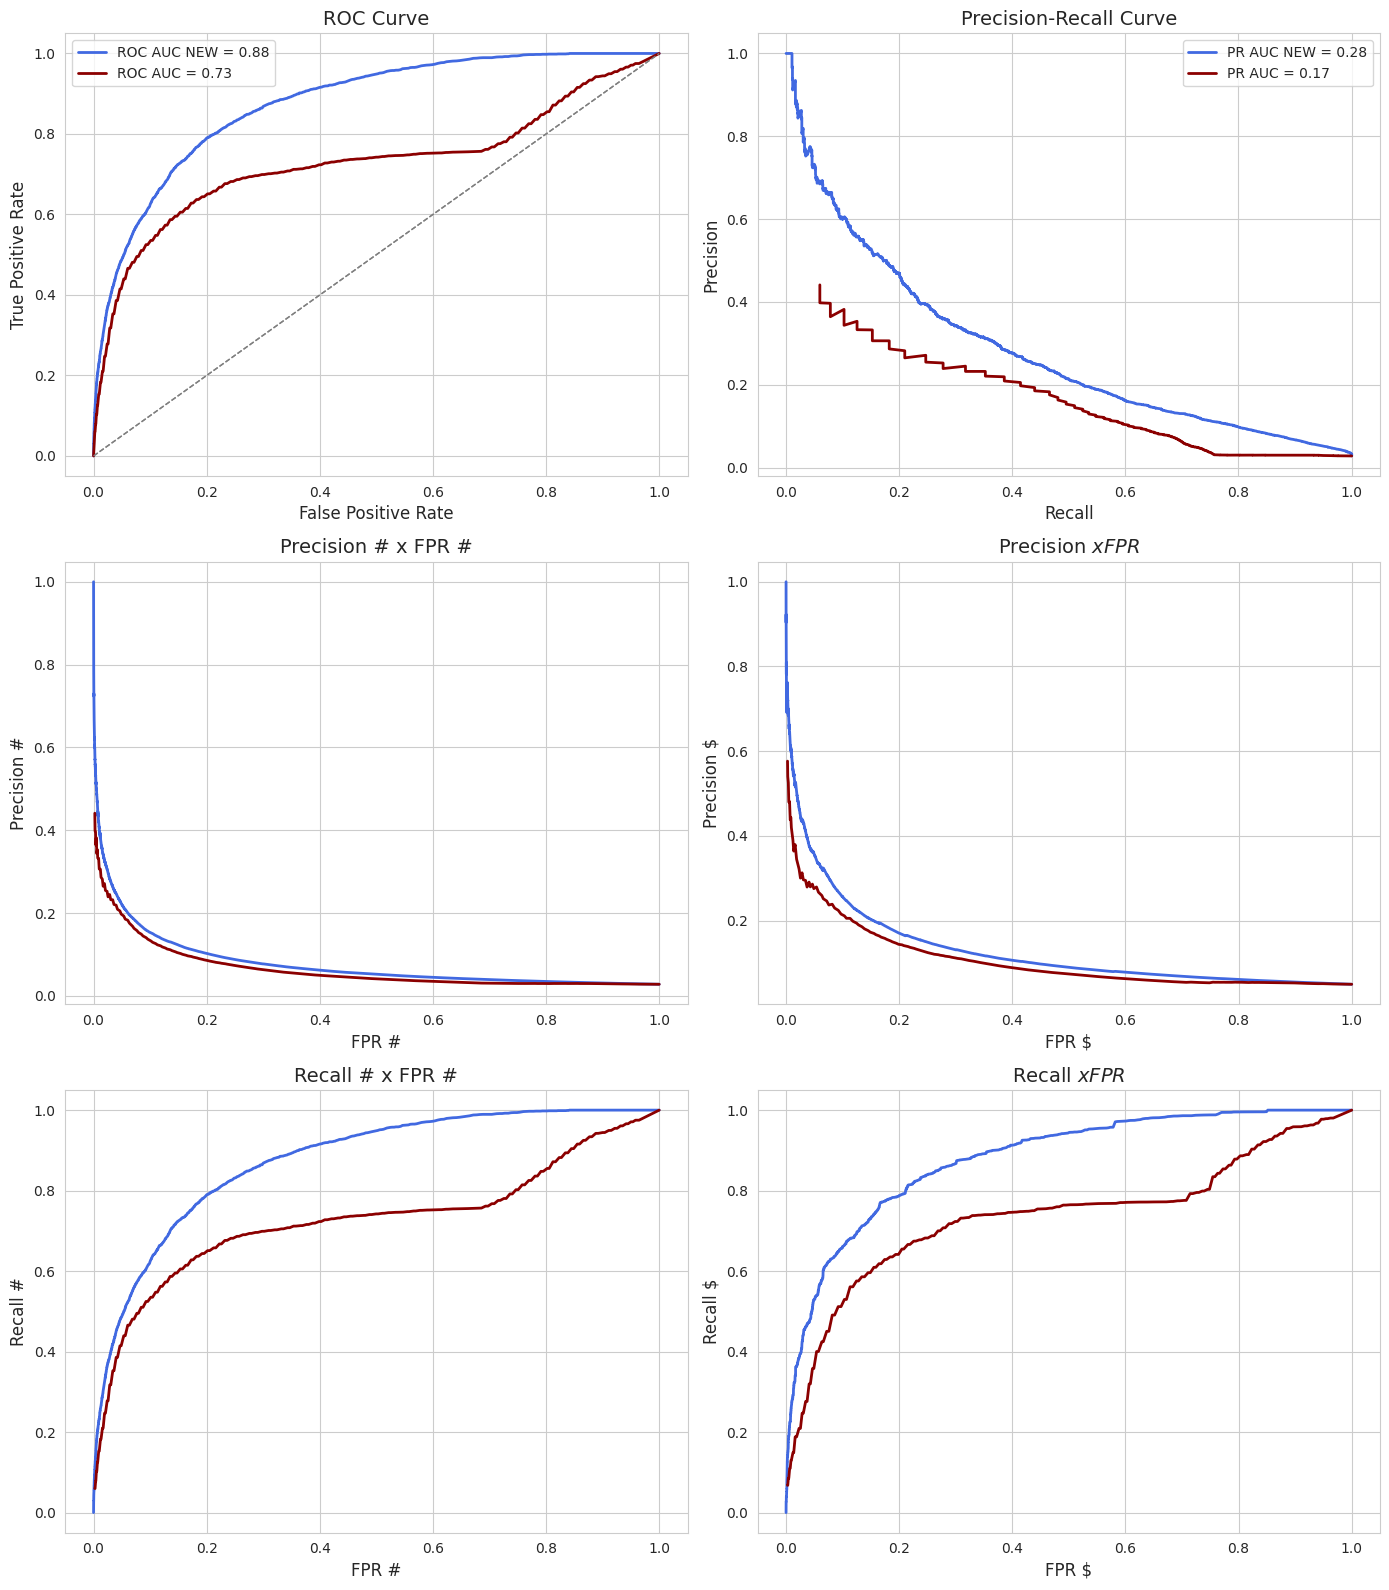

In [102]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(14, 16))
colors = ["royalblue", "darkred"]

# ROC Curve
fpr, tpr, th_roc = roc_curve(df_test['fraude'], df_test['new_score'])
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color=colors[0], linewidth=2, label=f'ROC AUC NEW = {roc_auc:.2f}')
axes[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)

fpr, tpr, th_roc = roc_curve(df_test['fraude'], df_test['score'])
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color=colors[1], linewidth=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14)
axes[0, 0].legend()

# Precision-Recall Curve
pr_auc = average_precision_score(df_test['fraude'], df_test['new_score'])
axes[0, 1].plot(df_thresholds['recall_#'], df_thresholds['precision_#'], color=colors[0], linewidth=2, label=f'PR AUC NEW = {pr_auc:.2f}')

pr_auc = average_precision_score(df_test['fraude'], df_test['score'])
axes[0, 1].plot(df_thresholds_old['recall_#'], df_thresholds_old['precision_#'], color=colors[1], linewidth=2, label=f'PR AUC = {pr_auc:.2f}')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14)
axes[0, 1].legend()

# Precision # x FPR #
axes[1, 0].plot(df_thresholds['fpr_#'], df_thresholds['precision_#'], color=colors[0], linewidth=2)
axes[1, 0].plot(df_thresholds_old['fpr_#'], df_thresholds_old['precision_#'], color=colors[1], linewidth=2)
axes[1, 0].set_xlabel('FPR #', fontsize=12)
axes[1, 0].set_ylabel('Precision #', fontsize=12)
axes[1, 0].set_title('Precision # x FPR #', fontsize=14)

# Precision $ x FPR $
axes[1, 1].plot(df_thresholds['fpr_$'], df_thresholds['precision_$'], color=colors[0], linewidth=2)
axes[1, 1].plot(df_thresholds_old['fpr_$'], df_thresholds_old['precision_$'], color=colors[1], linewidth=2)
axes[1, 1].set_xlabel('FPR $', fontsize=12)
axes[1, 1].set_ylabel('Precision $', fontsize=12)
axes[1, 1].set_title('Precision $ x FPR $', fontsize=14)

# Recall # x FPR #
axes[2, 0].plot(df_thresholds['fpr_#'], df_thresholds['recall_#'], color=colors[0], linewidth=2)
axes[2, 0].plot(df_thresholds_old['fpr_#'], df_thresholds_old['recall_#'], color=colors[1], linewidth=2)
axes[2, 0].set_xlabel('FPR #', fontsize=12)
axes[2, 0].set_ylabel('Recall #', fontsize=12)
axes[2, 0].set_title('Recall # x FPR #', fontsize=14)

# Recall $ x FPR $
axes[2, 1].plot(df_thresholds['fpr_$'], df_thresholds['recall_$'], color=colors[0], linewidth=2)
axes[2, 1].plot(df_thresholds_old['fpr_$'], df_thresholds_old['recall_$'], color=colors[1], linewidth=2)
axes[2, 1].set_xlabel('FPR $', fontsize=12)
axes[2, 1].set_ylabel('Recall $', fontsize=12)
axes[2, 1].set_title('Recall $ x FPR $', fontsize=14)


plt.tight_layout()
plt.show()

Comparando o novo score com o score antigo é possível notar uma melhor performance quando analisado todo o público nas métricas de ROC AUC, PR AUC, Recall e Precision quando analisado todo o público.  

In [103]:
print(f"ROCAUC New: {roc_auc_score(df_test['fraude'], df_test['new_score'])}")
print(f"ROCAUC Old: {roc_auc_score(df_test['fraude'], df_test['score'])}\n")

print(f"ROCAUC@1% New: {roc_auc_score(df_test['fraude'], df_test['new_score'], max_fpr=0.01)}")
print(f"ROCAUC@1% Old: {roc_auc_score(df_test['fraude'], df_test['score'], max_fpr=0.01)}")

ROCAUC New: 0.8763637283251161
ROCAUC Old: 0.728420266200116

ROCAUC@1% New: 0.5774404219580291
ROCAUC@1% Old: 0.5446779227955653


Avaliando pontos de impacto menores o score também tem um desempenho superior.  

### Distribuição

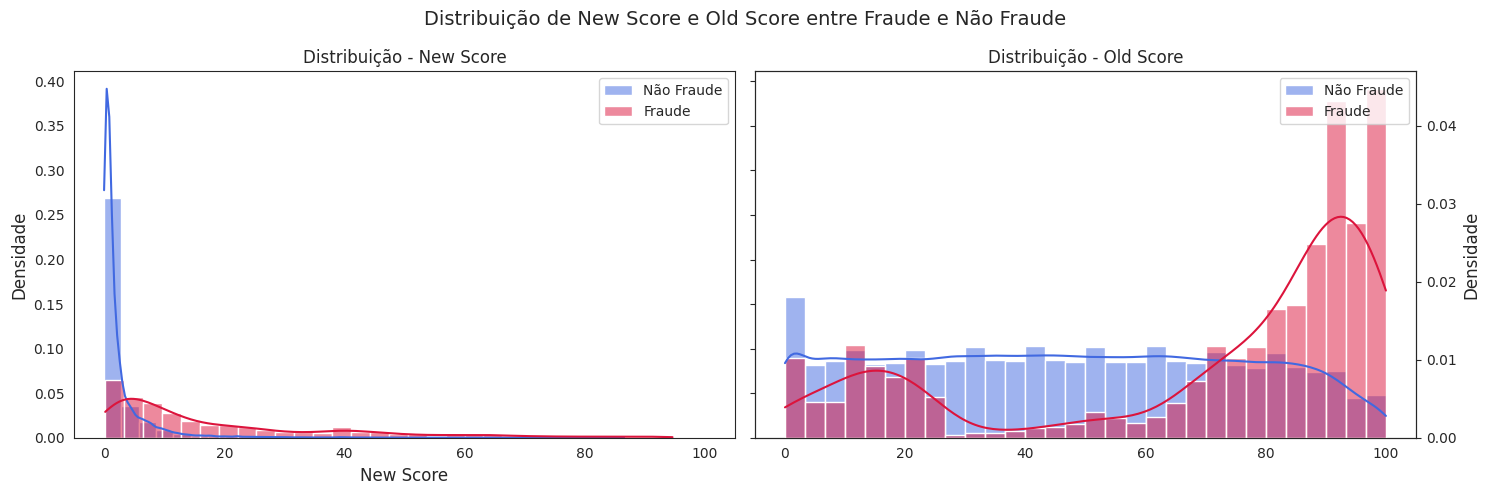

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)


sns.histplot(
    data=df[df['fraude'] == 0], x="new_score", kde=True, stat="density",
    bins=30, color="royalblue", alpha=0.5, label="Não Fraude", ax=axes[0]
)
sns.histplot(
    data=df[df['fraude'] == 1], x="new_score", kde=True, stat="density",
    bins=30, color="crimson", alpha=0.5, label="Fraude", ax=axes[0]
)
axes[0].set_title("Distribuição - New Score", fontsize=12)
axes[0].set_xlabel("New Score", fontsize=12)
axes[0].set_ylabel("Densidade", fontsize=12)
axes[0].legend(loc="upper right")

ax2 = axes[1].twinx()
sns.histplot(
    data=df[df['fraude'] == 0], x="score", kde=True, stat="density",
    bins=30, color="royalblue", alpha=0.5, label="Não Fraude", ax=ax2
)
sns.histplot(
    data=df[df['fraude'] == 1], x="score", kde=True, stat="density",
    bins=30, color="crimson", alpha=0.5, label="Fraude", ax=ax2
)
ax2.set_title("Distribuição - Old Score", fontsize=12)
ax2.set_xlabel("Old Score", fontsize=12)
ax2.set_ylabel("Densidade", fontsize=12)
ax2.legend(loc="upper right")

plt.suptitle("Distribuição de New Score e Old Score entre Fraude e Não Fraude", fontsize=14)
plt.tight_layout()
plt.show()


A distribuição do novo score também tem um formato muito diferente do antigo, acumulando muitas transações para próximo do 0, possibilitando faixas de score com menor FPR, facilitando a usabilidade em casos de baixissimo impacto no cliente final, o que não era possível com o antigo score, pois o corte 99.99 já tinha um FPR de 0.002604.  

### Avaliação ao longo do tempo

In [105]:
df['anomesdia'] = df['fecha'].astype(str).str[0:10].str.replace('-','', regex=True).astype(int)

In [106]:
df_auc_safrada = pd.DataFrame([
    [
        str(anomesdia),
        roc_auc_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['new_score']),
        average_precision_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['new_score']),
        df[df['anomesdia'] == anomesdia]['fraude'].mean(),
        df[df['anomesdia'] == anomesdia].shape[0],
        df[df['anomesdia'] == anomesdia]['fraude'].sum()
    ]
    for anomesdia in df['anomesdia'].unique()
], columns=['anomesdia', 'roc_auc', 'pr_auc', 'br', 'qtd_trans', 'qtd_fraude']).sort_values(by='anomesdia')

df_auc_safrada_old = pd.DataFrame([
    [
        str(anomesdia),
        roc_auc_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        average_precision_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        df[df['anomesdia'] == anomesdia]['fraude'].mean(),
        df[df['anomesdia'] == anomesdia].shape[0],
        df[df['anomesdia'] == anomesdia]['fraude'].sum()
    ]
    for anomesdia in df['anomesdia'].unique()
], columns=['anomesdia', 'roc_auc', 'pr_auc', 'br', 'qtd_trans', 'qtd_fraude']).sort_values(by='anomesdia')



In [107]:
df_auc_safrada['media_movel_roc_auc'] = df_auc_safrada['roc_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_pr_auc'] = df_auc_safrada['pr_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_br'] = df_auc_safrada['br'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_trans'] = df_auc_safrada['qtd_trans'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_fraude'] = df_auc_safrada['qtd_fraude'].rolling(window=7).mean()

df_auc_safrada_old['media_movel_roc_auc'] = df_auc_safrada_old['roc_auc'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_pr_auc'] = df_auc_safrada_old['pr_auc'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_br'] = df_auc_safrada_old['br'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_qtd_trans'] = df_auc_safrada_old['qtd_trans'].rolling(window=7).mean()
df_auc_safrada_old['media_movel_qtd_fraude'] = df_auc_safrada_old['qtd_fraude'].rolling(window=7).mean()

/tmp/ipykernel_2871/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_2871/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_2871/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_2871/3950764045.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_2871/3950764045.py:24: UserWarning: set_ticklabel

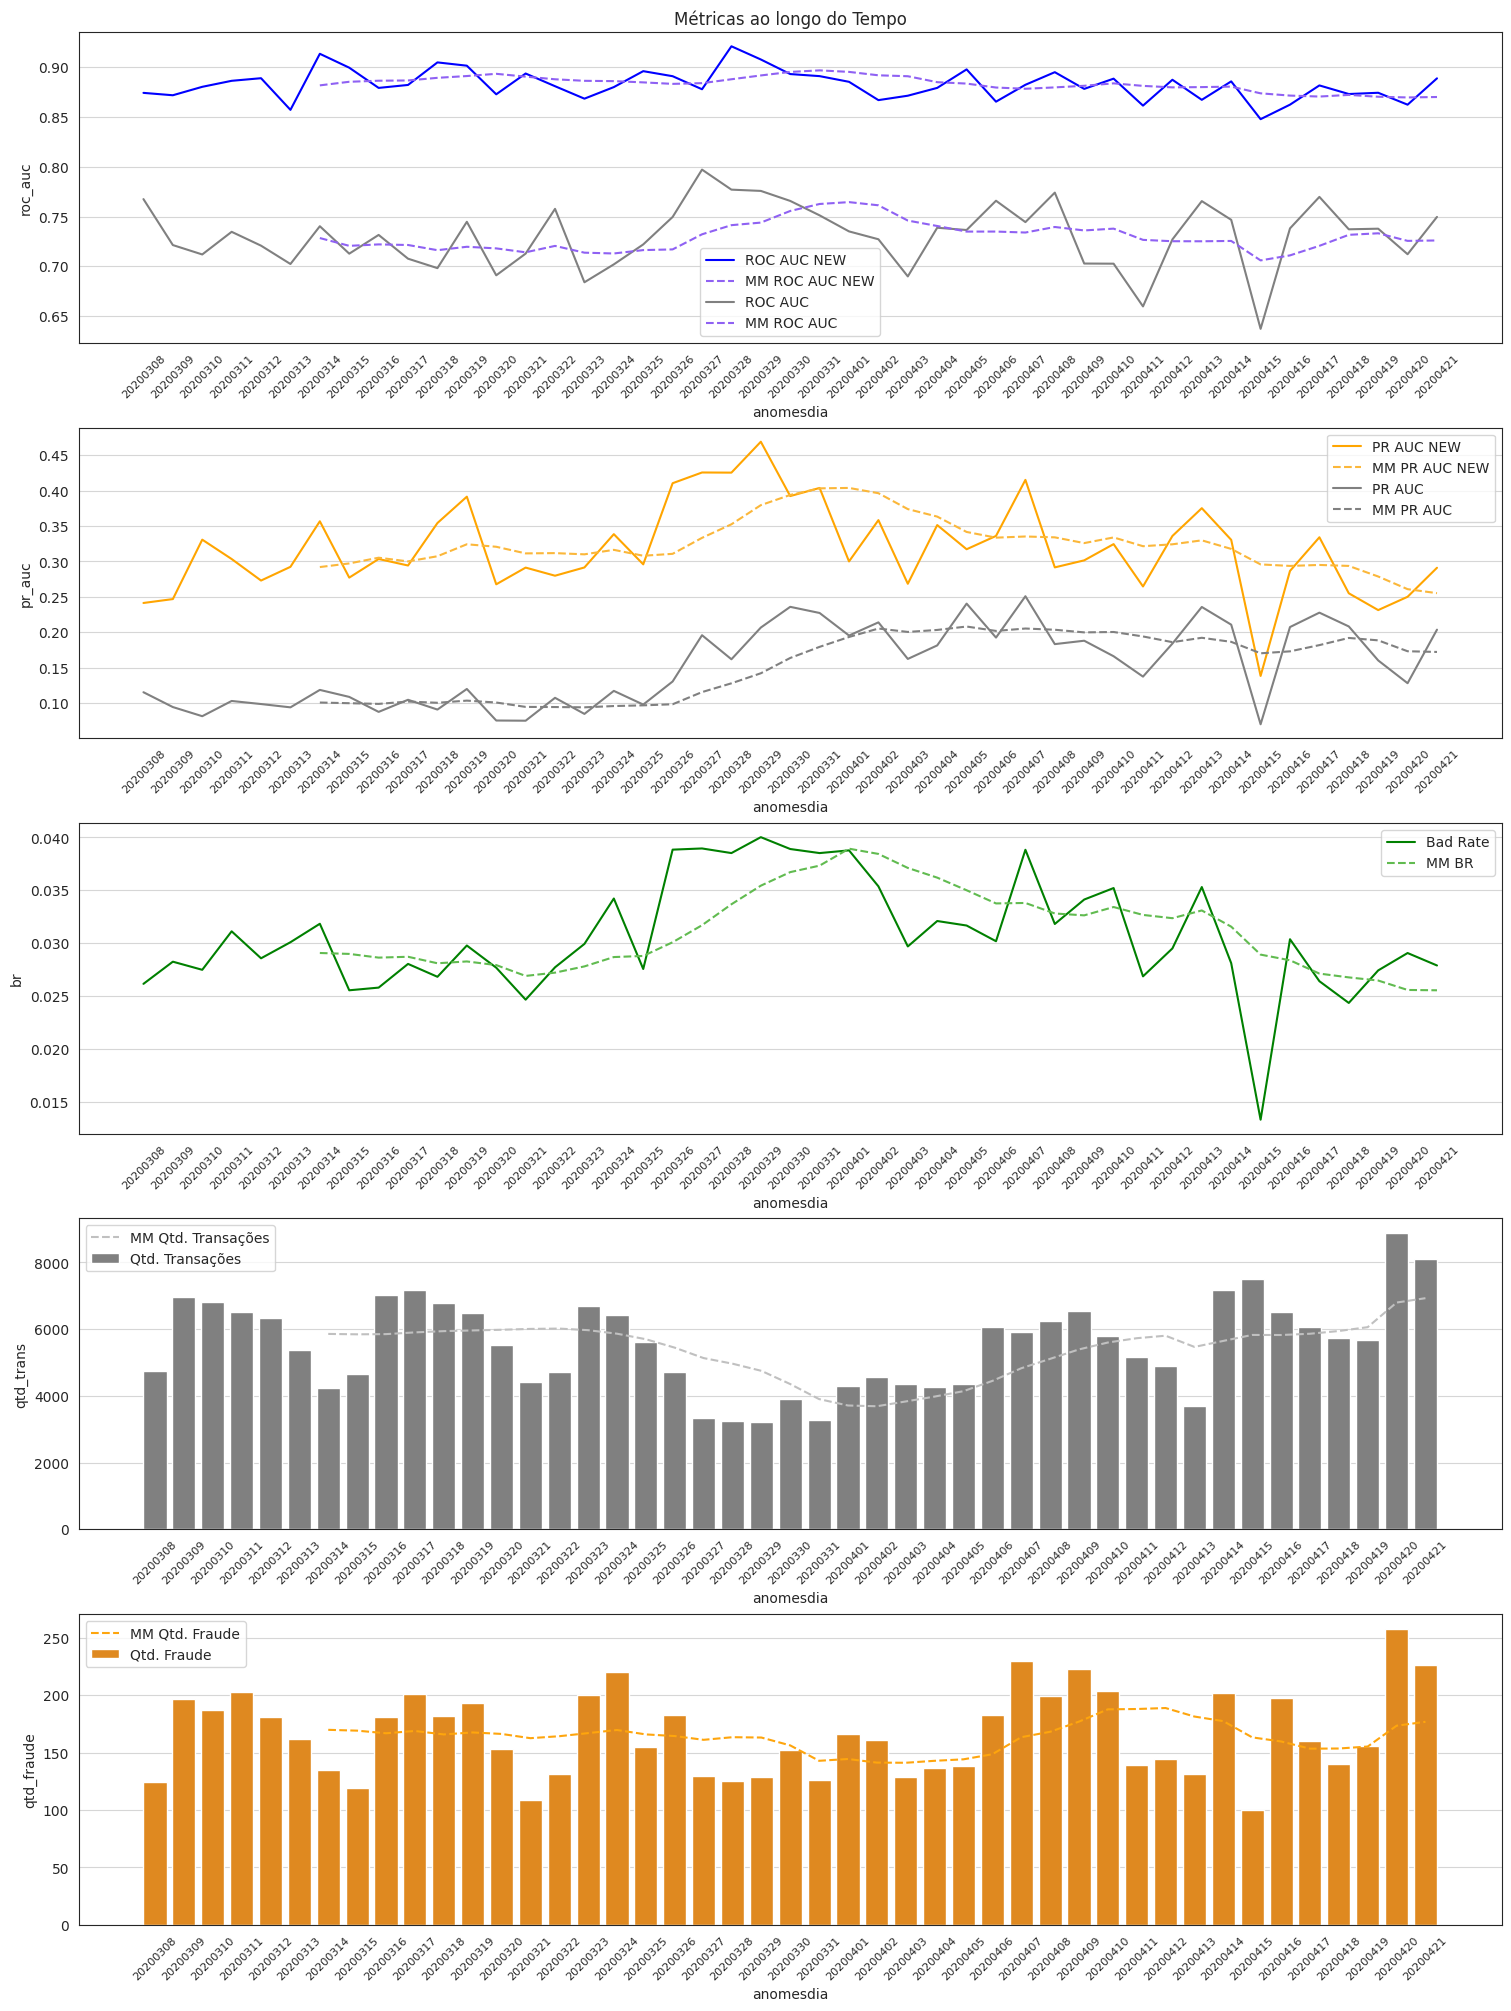

In [108]:
sns.set_style("white")

fig, axes = plt.subplots(5, 1, figsize=(15, 20),constrained_layout=True)
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='roc_auc', label='ROC AUC NEW', ax=axes[0], color='blue')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_roc_auc', label='MM ROC AUC NEW', ax=axes[0], linestyle="--", color='#8f61f3')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='roc_auc', label='ROC AUC', ax=axes[0], color='gray')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='media_movel_roc_auc', label='MM ROC AUC', ax=axes[0], linestyle="--", color='#8f61f3')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='pr_auc', label='PR AUC NEW', ax=axes[1], color='orange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_pr_auc', label='MM PR AUC NEW', ax=axes[1], linestyle="--", color='#fbb73a')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='pr_auc', label='PR AUC', ax=axes[1], color='gray')
sns.lineplot(data=df_auc_safrada_old, x='anomesdia', y='media_movel_pr_auc', label='MM PR AUC', ax=axes[1], linestyle="--", color='gray')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='br', label='Bad Rate', ax=axes[2], color='green')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_br', label='MM BR', ax=axes[2], linestyle="--", color='#61bb50')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_trans', label='Qtd. Transações', ax=axes[3], color='grey')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_trans', label='MM Qtd. Transações', ax=axes[3], linestyle="--", color='#c0c0c0')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_fraude', label='Qtd. Fraude', ax=axes[4], color='darkorange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_fraude', label='MM Qtd. Fraude', ax=axes[4], linestyle="--", color='#fea50d')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
    ax.grid(axis='y', linestyle="-", alpha=0.8)

axes[0].set_title('Métricas ao longo do Tempo')
plt.show()

Avaliando o comportamento ao longo do tempo o novo score também é superior ao antigo, mostrando estabilidade e consistência, sempre acompanhando a bad rate.  

### Estabilidade do Score

In [109]:
# Vou utilizar como referência a primeira semana do dataset

ks_day_map = {
    'Sunday' : 20200308,
    'Monday' : 20200309,
    'Tuesday' : 20200310,
    'Wednesday' : 20200311,
    'Thursday' : 20200312,
    'Friday' : 20200313,
    'Saturday' : 20200314
}

df_ks_safrado = pd.DataFrame(
    [
        [
            str(anomesdia),
            kstest(df[df['anomesdia'] == ks_day_map.get(datetime.strptime(str(anomesdia), "%Y%m%d").strftime("%A"))]['new_score'], 
                   df[df['anomesdia'] == anomesdia]['new_score'])[0]
        ]
        for anomesdia in df['anomesdia'].unique() if int(anomesdia) >= 20200315
    ],
    columns=['anomesdia', 'ks']
).sort_values(by='anomesdia')

In [110]:
df['faixa_score'] = pd.cut(df['new_score'], bins=range(0, 100, 5), include_lowest=True)
df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)
df_percentual = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
df_percentual.index = df_percentual.index.astype(str)

/tmp/ipykernel_2871/1463839929.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)


/tmp/ipykernel_2871/124477336.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)


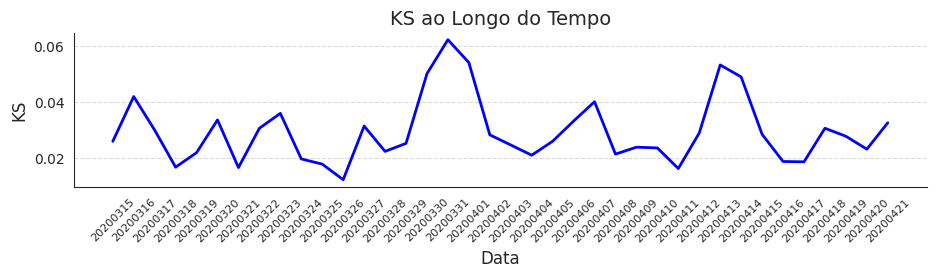

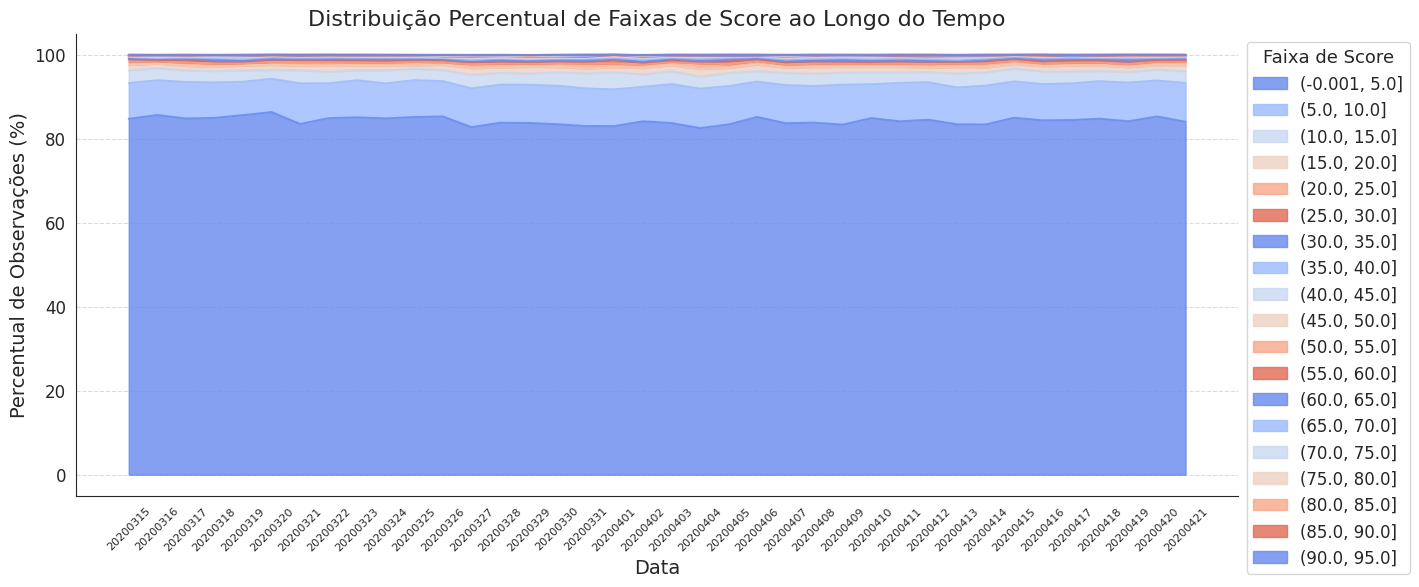

In [111]:
# KS
plt.figure(figsize=(11, 2))

sns.set_palette("coolwarm")

ax = sns.lineplot(data=df_ks_safrado, x='anomesdia', y='ks', linewidth=2, color='blue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

ax.set_title('KS ao Longo do Tempo', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('KS', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Distribuição Faixas de Score
ax = df_percentual.plot(kind='area', stacked=True, figsize=(15, 6), alpha=0.8)

plt.xlabel("Data", fontsize=14)
plt.ylabel("Percentual de Observações (%)", fontsize=14)
plt.title("Distribuição Percentual de Faixas de Score ao Longo do Tempo", fontsize=16)

plt.xticks(ticks=np.arange(len(df_percentual.index)), labels=df_percentual.index, rotation=45, fontsize=8)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(title="Faixa de Score", fontsize=12, title_fontsize=13, loc='upper left', bbox_to_anchor=(1, 1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

Avaliando um teste de estabilidade, o novo score demonstra sazonalidades na métrica do KS, porêm se mantêm constrolado com KS <= 0.06.  

# Explicabilidade

In [112]:
df_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
df_importance['importance_cumsum'] = df_importance['importance'].cumsum()
df_importance['importance_perc'] = df_importance['importance_cumsum'] / df_importance['importance_cumsum'].max()
df_importance

feature    importance  importance_cumsum  importance_perc
0                      o  26174.503150       26174.503150         0.397657
1                      a  10578.243929       36752.747078         0.558368
2                      n   5618.272954       42371.020033         0.643724
3                      f   5152.170428       47523.190461         0.721998
4                      m   4880.753985       52403.944446         0.796149
5      br_qty_cat_last7d   3830.148989       56234.093434         0.854339
6                      l   3389.039439       59623.132874         0.905827
7                      b   2514.925781       62138.058654         0.944035
8                      d   1413.347558       63551.406212         0.965508
9   qty_fraud_cat_last7d    905.572300       64456.978512         0.979266
10   vl_fraud_cat_last7d    832.814425       65289.792938         0.991918
11                     s    277.919064       65567.712002         0.996141
12      br_vl_cat_last7d    254.027442       65821.739444         1.000000

In [113]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(df[model.feature_names_in_])

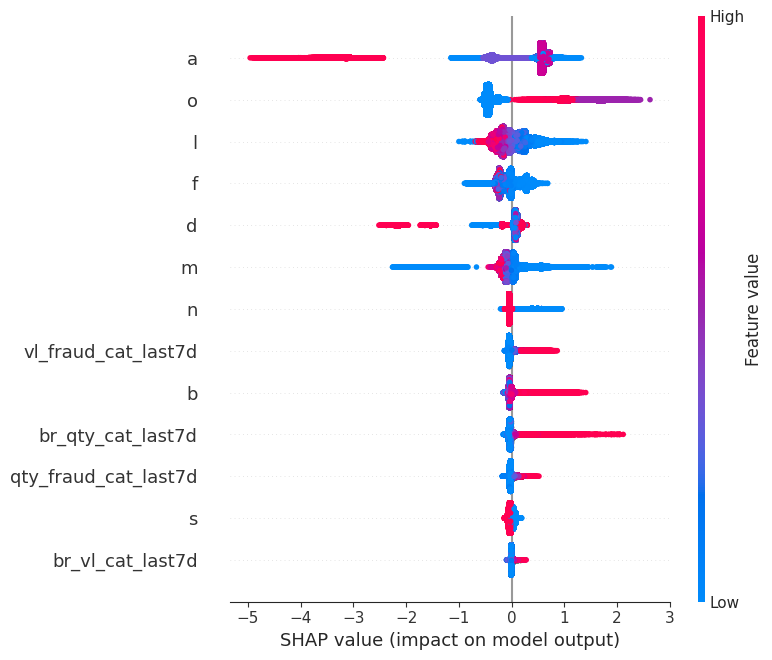

In [114]:
shap.summary_plot(shap_values, df[model.feature_names_in_])

Como não temos o que é cada coluna, não conseguimos explicar muito bem o que impacta positivamente e negativament o score. Porêm as colunas que construimos, sobre distribuições de fraude e total de transações por categoria de produto conseguimos descrever.  
Ambas as colunas de quantidade de fraude e valor de fraude entraram no modelo e tiveram o comportamento esperado, tem uma distribuição próxima do 0, indicando que poucas categorias tem fraude, porém quanto maior o seu valor, maior a chance de ocorrerem fraudes nesse produto, impactando positivamente no score.  

# Usabilidade

In [115]:
import pandas as pd
import numpy as np
import pickle
from sklearn.tree import DecisionTreeClassifier

# Data

In [116]:
df = pd.read_parquet('../data/encoded/fraud_dataset_v2_test.parquet.gzip')

In [117]:
model = pickle.load(open('../model/predictors/lgbm_model.pkl', 'rb'))

In [118]:
df['new_score'] = (model.predict_proba(df[model.feature_names_in_])[:,1]*100).round(0)
df['score'] = (df['score']).round(0)
df['monto_fraude'] = df['monto'] * df['fraude']
df['monto_not_fraude'] = df['monto'] * abs(df['fraude'] - 1)

In [119]:
df.head(2)

a       b        c     d         e     f   g   h  \
0  4  0.7550   9258.5   1.0  0.000000  33.0  BR   0   
1  4  0.7631  18923.9  50.0  0.482385  18.0  BR  23   

                                                   i            j         k  \
0  Avental Descartavel Manga Longa  - 50 Un. Tnt ...  cat_64b574b  0.376019   
1  Caneta Delineador Carimbo Olho Gatinho Longo 2...  cat_d06e653  0.154036   

        l       m  n  o  p     q      r    s               fecha   monto  \
0  4008.0     0.0  1  2  N  0.02   9258    0 2020-04-15 19:58:08  124.71   
1  1704.0  1147.0  1  0  Y  0.98  18923  100 2020-04-16 16:03:10    3.54   

   score  fraude       ymd  day_of_week  hour_of_day period_of_day  \
0   72.0       0  20200415            2           19       evening   
1    2.0       0  20200416            3           16     afternoon   

   vl_cat_last7d  qty_cat_last7d  vl_fraud_cat_last7d  qty_fraud_cat_last7d  \
0        1070.50            63.0                46.75                   2.0   
1           3.67             2.0                 0.00                   0.0   

   br_vl_cat_last7d  br_qty_cat_last7d  new_score  monto_fraude  \
0          0.043671           0.031746        4.0           0.0   
1          0.000000           0.000000        1.0           0.0   

   monto_not_fraude  
0            124.71  
1              3.54

# Usabilidade

## Scores Separados

In [120]:
df_thresholds = (
    df
    .groupby(['new_score'])
    .agg({
        'monto' : ['count', 'sum'],
        'fraude' : 'sum',
        'monto_fraude' : 'sum',
        'monto_not_fraude' : 'sum'
    })
    .sort_values(by=['new_score'], ascending=False)
    .cumsum()
)
df_thresholds['monto_not_fraude_aprovada'] = df_thresholds['monto_not_fraude'].max() - df_thresholds['monto_not_fraude']
df_thresholds['monto_fraude_aprovada'] = df_thresholds['monto_fraude'].max() - df_thresholds['monto_fraude']
df_thresholds['roi'] = df_thresholds['monto_not_fraude_aprovada'] * 0.05 - df_thresholds['monto_fraude_aprovada']

df_thresholds.columns = ['qty_trans', 'vl_trans', 'qty_fraud', 'vl_fraud', 'vl_not_fraud', 'vl_not_fraud_approved', 'vl_fraud_approved', 'roi']

In [121]:
df_thresholds_old = (
    df
    .groupby(['score'])
    .agg({
        'monto' : ['count', 'sum'],
        'fraude' : 'sum',
        'monto_fraude' : 'sum',
        'monto_not_fraude' : 'sum'
    })
    .sort_values(by=['score'], ascending=False)
    .cumsum()
)
df_thresholds_old['monto_not_fraude_aprovada'] = df_thresholds_old['monto_not_fraude'].max() - df_thresholds_old['monto_not_fraude']
df_thresholds_old['monto_fraude_aprovada'] = df_thresholds_old['monto_fraude'].max() - df_thresholds_old['monto_fraude']
df_thresholds_old['roi'] = df_thresholds_old['monto_not_fraude_aprovada'] * 0.05 - df_thresholds_old['monto_fraude_aprovada']

df_thresholds_old.columns = ['qty_trans', 'vl_trans', 'qty_fraud', 'vl_fraud', 'vl_not_fraud', 'vl_not_fraud_approved', 'vl_fraud_approved', 'roi']

In [122]:
df_thresholds[df_thresholds['roi'] == df_thresholds['roi'].max()]

qty_trans   vl_trans  qty_fraud   vl_fraud  vl_not_fraud  \
new_score                                                             
4.0            18662  952623.91       1942  149075.96     803547.95   

           vl_not_fraud_approved  vl_fraud_approved          roi  
new_score                                                         
4.0                   2664725.63           31594.34  101641.9415

In [123]:
df_thresholds_old[df_thresholds_old['roi'] == df_thresholds_old['roi'].max()]

qty_trans   vl_trans  qty_fraud   vl_fraud  vl_not_fraud  \
score                                                             
77.0       13156  722680.25       1456  113626.81     609053.44   

       vl_not_fraud_approved  vl_fraud_approved        roi  
score                                                       
77.0              2859220.14           67043.49  75917.517

Observando o ROI, chegamos a conclusão de que o novo score tem um ponto de corte que traz mais lucro para a empresa, aumentando em 27k, 36%.  Além de maior captura de fraude em quantidades, aumentando em 32%.  